# Smart Budget Recommender — **Data Understanding & Preprocessing** (Google Colab)
Dataset: **Family Income and Expenditure** (Filipino Household Survey, Kaggle)

Berikut langkah-langkah yang dilakukan dalam proses pembuatan machine learning berikut:  
1) Memahami struktur data (**kolom, tipe, missing, duplikat, outlier**).  
2) Melakukan **cleaning & wrangling** (membersihkan dataset).  
3) Melakukan **preprocessing** (rename, capping outlier).  
4) Melakukan **EDA bermakna** yang relevan untuk **budgeting bulanan**.


## 1) Import Library & Konfigurasi
Kami hanya menggunakan `pandas`, `numpy`, `matplotlib`, dan beberapa library `sklearn` untuk analisis & pre-processing.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import joblib
import os

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

2025-10-27 00:35:27.498785: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-27 00:35:27.525636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-27 00:35:27.541913: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-27 00:35:27.548134: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-27 00:35:27.566939: I tensorflow/core/platform/cpu_feature_guar

## 2) Load Dataset
- Gunakan nama file yang sudah disepakati: **`Family Income and Expenditure.csv`**.
- Tujuan sel ini: memastikan file terbaca, melihat **shape** serta preview beberapa baris.


In [2]:
df = pd.read_csv('Family Income and Expenditure.csv')
print('Shape:', df.shape)
df.head(5)

Shape: (41544, 60)


,Total Household Income,Region,Total Food Expenditure,Main Source of Income,Agricultural Household indicator,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,Tobacco Expenditure,"Clothing, Footwear and Other Wear Expenditure",Housing and water Expenditure,Imputed House Rental Value,Medical Care Expenditure,Transportation Expenditure,Communication Expenditure,Education Expenditure,Miscellaneous Goods and Services Expenditure,Special Occasions Expenditure,Crop Farming and Gardening expenses,Total Income from Entrepreneurial Acitivites,Household Head Sex,Household Head Age,Household Head Marital Status,Household Head Highest Grade Completed,Household Head Job or Business Indicator,Household Head Occupation,Household Head Class of Worker,Type of Household,Total Number of Family members,Members with age less than 5 year old,Members with age 5 - 17 years old,Total number of family members employed,Type of Building/House,Type of Roof,Type of Walls,House Floor Area,House Age,Number of bedrooms,Tenure Status,Toilet Facilities,Electricity,Main Source of Water Supply,Number of Television,Number of CD/VCD/DVD,Number of Component/Stereo set,Number of Refrigerator/Freezer,Number of Washing Machine,Number of Airconditioner,"Number of Car, Jeep, Van",Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle
0,480332,CAR,117848,Wage/Salaries,0,42140,38300,24676,16806,3325,13460,3000,0,0,4607,63636,30000,3457,4776,2880,36200,34056,7200,19370,44370,Female,49,Single,Teacher Training and Education Sciences Programs,With Job/Business,General elementary education teaching professi...,Worked for government/government corporation,Extended Family,4,0,1,1,Single house,"Strong material(galvanized,iron,al,tile,concre...",Strong,80,75,3,Own or owner-like possession of house and lot,"Water-sealed, sewer septic tank, used exclusiv...",1,"Own use, faucet, community water system",1,1,0,1,1,0,0,0,2,1,0,0,1
1,198235,CAR,67766,Wage/Salaries,0,17329,13008,17434,11073,2035,7833,2360,960,2132,8230,41370,27000,3520,12900,5700,29300,9150,1500,0,0,Male,40,Married,Transport Services Programs,With Job/Business,Transport conductors,Worked for private establishment,Single Family,3,0,1,2,Single house,"Strong material(galvanized,iron,al,tile,concre...",Strong,42,15,2,Own or owner-like possession of house and lot,"Water-sealed, sewer septic tank, used exclusiv...",1,"Own use, faucet, community water system",1,1,1,0,1,0,0,0,3,1,0,0,2
2,82785,CAR,61609,Wage/Salaries,1,34182,32001,7783,2590,1730,3795,4545,270,4525,2735,14340,7200,70,324,420,425,6450,500,0,0,Male,39,Married,Grade 3,With Job/Business,Farmhands and laborers,Worked for private establishment,Single Family,6,0,4,3,Single house,"Light material (cogon,nipa,anahaw)",Light,35,12,1,Own or owner-like possession of house and lot,"Water-sealed, sewer septic tank, shared with o...",0,"Shared, faucet, community water system",0,0,0,0,0,0,0,0,0,0,0,0,0
3,107589,CAR,78189,Wage/Salaries,0,34030,28659,10914,10812,690,7887,6280,480,0,1390,16638,6600,60,6840,660,300,3762,500,15580,15580,Male,52,Married,Elementary Graduate,With Job/Business,Rice farmers,Employer in own family-operated farm or business,Single Family,3,0,3,2,Single house,"Light material (cogon,nipa,anahaw)",Light,30,15,1,Own or owner-like possession of house and lot,Closed pit,1,"Own use, faucet, community water system",1,0,0,0,0,0,0,0,1,0,0,0,0
4,189322,CAR,94625,Wage/Salaries,0,34820,30167,18391,11309,1395,11260,6400,1040,0,4620,31122,16800,140,6996,2100,0,8472,1000,18887,75687,Male,65,Married,Elementary Graduate,With Job/Business,General managers/managing proprietors in trans...,Self-employed wihout any employee,Single Family,4,0,0,2,Single house,"Light material (cogon,nipa,an

## 3) Data Understanding — Struktur & Skema
Untuk mengetahui **kolom** dan **tipe data** supaya mengerti bentuk dan kolom-kolom yang ada di dataset saat preprocessing & modelling.


In [3]:
schema = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.astype(str),
    "nunique": [df[c].nunique(dropna=True) for c in df.columns]
}).sort_values("column")
schema.head(60)

,column,dtype,nunique
Agricultural Household indicator,Agricultural Household indicator,int64,3
Alcoholic Beverages Expenditure,Alcoholic Beverages Expenditure,int64,4084
Bread and Cereals Expenditure,Bread and Cereals Expenditure,int64,26082
"Clothing, Footwear and Other Wear Expenditure","Clothing, Footwear and Other Wear Expenditure",int64,9819
Communication Expenditure,Communication Expenditure,int64,3826
Crop Farming and Gardening expenses,Crop Farming and Gardening expenses,int64,9961
Education Expenditure,Education Expenditure,int64,6893
Electricity,Electricity,int64,2
Fruit Expenditure,Fruit Expenditure,int64,7140
House Age,House Age,int64,111


In [4]:
# Informasi ringkas

# 1. Cek dimensi data (jumlah baris x kolom)
print("Shape dataset:", df.shape)

# 2. Cek informasi struktur data (tipe data, jumlah non-null per kolom)
print("\n=== Info Dataset ===")
df.info()

# 3. Statistik deskriptif untuk kolom numerik (mean, std, min, max, quartiles)
print("\n=== Deskripsi Statistik (Numerik) ===")
print(df.describe().T)

# 4. Statistik deskriptif untuk kolom kategorikal (object)
print("\n=== Deskripsi Statistik (Kategorikal) ===")
print(df.describe(include=['object']).T)

# 5. Jumlah nilai hilang (NaN) per kolom
print("\n=== Missing Values per Kolom ===")
print(df.isna().sum())

# 6. Jumlah nilai unik per kolom
print("\n=== Jumlah Nilai Unik per Kolom ===")
print(df.nunique())

# 7. Jumlah baris duplikat
print("\n=== Jumlah Baris Duplikat ===")
print(df.duplicated().sum())


Shape dataset: (41544, 60)

=== Info Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41544 entries, 0 to 41543
Data columns (total 60 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   Total Household Income                         41544 non-null  int64 
 1   Region                                         41544 non-null  object
 2   Total Food Expenditure                         41544 non-null  int64 
 3   Main Source of Income                          41544 non-null  object
 4   Agricultural Household indicator               41544 non-null  int64 
 5   Bread and Cereals Expenditure                  41544 non-null  int64 
 6   Total Rice Expenditure                         41544 non-null  int64 
 7   Meat Expenditure                               41544 non-null  int64 
 8   Total Fish and  marine products Expenditure    41544 non-null  int64 
 9   Fruit Expend

In [5]:
# Cek persentase missing value

missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean()*100).round(2).sort_values(ascending=False)
missing_df = pd.DataFrame({"missing": missing, "missing_%": missing_pct})
missing_df.head(60)

,missing,missing_%
Household Head Occupation,7536,18.14
Household Head Class of Worker,7536,18.14
Toilet Facilities,1580,3.80
Number of Stove with Oven/Gas Range,0,0.00
Type of Household,0,0.00
Total Number of Family members,0,0.00
Members with age less than 5 year old,0,0.00
Members with age 5 - 17 years old,0,0.00
Total number of family members employed,0,0.00
Type of Building/House,0,0.00


In [6]:
# Cek kolom dengan nilai negatif karena nilai negatif untuk income/pengeluaran biasanya tidak masuk akal (atau noise input)

num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
neg_counts = {c: int((df[c] < 0).sum()) for c in num_cols}
neg_df = pd.Series(neg_counts, name="neg_count").sort_values(ascending=False)
neg_df.head(60)

Total Household Income                           0
Household Head Age                               0
Members with age less than 5 year old            0
Members with age 5 - 17 years old                0
Total number of family members employed          0
House Floor Area                                 0
House Age                                        0
Number of bedrooms                               0
Electricity                                      0
Number of Television                             0
Number of CD/VCD/DVD                             0
Number of Component/Stereo set                   0
Number of Refrigerator/Freezer                   0
Number of Washing Machine                        0
Number of Airconditioner                         0
Number of Car, Jeep, Van                         0
Number of Landline/wireless telephones           0
Number of Cellular phone                         0
Number of Personal Computer                      0
Number of Stove with Oven/Gas R

## 4) Identifikasi Kolom Penting (Income & Expenditure)
**Tujuan**: Mengetahui kolom-kolom yang relevan untuk budgeting (pendapatan & kategori pengeluaran).  
Kami gunakan heuristik nama kolom.


In [7]:
import re

income_candidates = [c for c in df.columns if re.search(r'income|earn|wage|salary', c, flags=re.I)]
expenditure_candidates = [c for c in df.columns if re.search(
    r'exp|expend|spend|outlay|cost|food|transport|housing|health|edu|recreation|alcohol|clothing|misc|utilities|communication|hotel|restaurant|tobacco|water|rice|fish|meat|fruit|vegetable|medical|education|gardening|crop',
    c, flags=re.I)]

print('Income candidates:', income_candidates)
print('\nExpenditure candidates (preview):', expenditure_candidates[:20])

Income candidates: ['Total Household Income', 'Main Source of Income', 'Total Income from Entrepreneurial Acitivites']

Expenditure candidates (preview): ['Total Food Expenditure', 'Bread and Cereals Expenditure', 'Total Rice Expenditure', 'Meat Expenditure', 'Total Fish and  marine products Expenditure', 'Fruit Expenditure', 'Vegetables Expenditure', 'Restaurant and hotels Expenditure', 'Alcoholic Beverages Expenditure', 'Tobacco Expenditure', 'Clothing, Footwear and Other Wear Expenditure', 'Housing and water Expenditure', 'Medical Care Expenditure', 'Transportation Expenditure', 'Communication Expenditure', 'Education Expenditure', 'Miscellaneous Goods and Services Expenditure', 'Special Occasions Expenditure', 'Crop Farming and Gardening expenses', 'Main Source of Water Supply']


In [8]:
pd.options.display.float_format = '{:,.2f}'.format
summary_income = df[income_candidates].describe().T if income_candidates else pd.DataFrame()
summary_expense = df[expenditure_candidates].describe().T if expenditure_candidates else pd.DataFrame()

print('Ringkas Income:')
display(summary_income.head(10))
print('\nRingkas Expenditure:')
display(summary_expense.head(15))

Ringkas Income:


,count,mean,std,min,25%,50%,75%,max
Total Household Income,"41,544.00","247,555.58","286,880.52","11,285.00","104,895.00","164,079.50","291,138.50","11,815,988.00"
Total Income from Entrepreneurial Acitivites,"41,544.00","54,376.24","147,142.79",0.00,0.00,"19,222.00","65,968.75","9,234,485.00"



Ringkas Expenditure:


,count,mean,std,min,25%,50%,75%,max
Total Food Expenditure,"41,544.00","85,099.16","51,637.95","2,947.00","51,017.25","72,985.50","105,635.50","827,565.00"
Bread and Cereals Expenditure,"41,544.00","25,133.72","13,466.48",0.00,"16,556.00","23,324.00","31,439.00","765,864.00"
Total Rice Expenditure,"41,544.00","18,195.83","11,727.22",0.00,"11,020.00","16,620.00","23,920.00","758,326.00"
Meat Expenditure,"41,544.00","10,540.07","10,497.73",0.00,"3,353.75","7,332.50","14,292.00","261,566.00"
Total Fish and marine products Expenditure,"41,544.00","10,529.32","7,812.20",0.00,"5,504.00","8,695.00","13,388.00","188,208.00"
Fruit Expenditure,"41,544.00","2,550.47","2,969.75",0.00,"1,024.75","1,820.00","3,100.00","273,769.00"
Vegetables Expenditure,"41,544.00","5,006.92","3,300.18",0.00,"2,873.00","4,314.00","6,304.25","74,800.00"
Restaurant and hotels Expenditure,"41,544.00","15,436.57","23,705.20",0.00,"1,930.00","7,314.00","19,921.25","725,296.00"
Alcoholic Beverages Expenditure,"41,544.00","1,085.07","2,174.43",0.00,0.00,270.00,"1,299.25","59,592.00"
Tobacco Expenditure,"41,544.00","2,294.74","3,998.98",0.00,0.00,300.00,"3,146.50","139,370.00"


## 5) Standarisasi Nama Kolom → `snake_case`
Untuk memudahkan pemanggilan & automasi. Di bawah ini juga ditampilkan **mapping** dari nama asli → `snake_case`.


In [9]:
def to_snake(s: str) -> str:
    import re
    s = s.strip()
    s = re.sub(r"[^\w\s]", " ", s)
    s = re.sub(r"\s+", "_", s)
    return s.lower()

original_cols = df.columns.tolist()
df.columns = [to_snake(c) for c in df.columns]
mapping = pd.DataFrame({"original": original_cols, "snake_case": df.columns})
mapping.head(30)

,original,snake_case
0,Total Household Income,total_household_income
1,Region,region
2,Total Food Expenditure,total_food_expenditure
3,Main Source of Income,main_source_of_income
4,Agricultural Household indicator,agricultural_household_indicator
5,Bread and Cereals Expenditure,bread_and_cereals_expenditure
6,Total Rice Expenditure,total_rice_expenditure
7,Meat Expenditure,meat_expenditure
8,Total Fish and marine products Expenditure,total_fish_and_marine_products_expenditure
9,Fruit Expenditure,fruit_expenditure


## 6) Identifikasi Kolom Income & Expenditure (untuk keperluan EDA)
Tujuan: menentukan kolom pendapatan dan pengeluaran utama **tanpa menyimpan hasil ke DataFrame**.  
- `income_cols`: semua kolom yang mengandung kata *income*.  
- `exp_cols`: semua kolom yang mengandung *expenditure* atau diakhiri *expenses*.  
- `primary_income_col`: preferensi `'total_household_income'` jika ada, jika tidak gunakan kolom income pertama yang tersedia.  
- `total_expenditure_col`: jika dataset menyediakan kolom total pengeluaran bawaan, gunakan; jika tidak, total pengeluaran akan dihitung **sementara** pada sel-sel tertentu untuk analisis.

In [10]:
# Deteksi kolom terkait income & expenditure
income_cols = [c for c in df.columns if "income" in c]
exp_cols = [c for c in df.columns if ("expenditure" in c) or c.endswith("expenses")]

# Pilih income representatif
if "total_household_income" in df.columns:
    primary_income_col = "total_household_income"
else:
    primary_income_col = income_cols[0] if income_cols else None

# Kolom total pengeluaran jika tersedia (opsional)
total_exp_candidates = [c for c in df.columns if re.search(r'^total_.*expend', c)]
total_expenditure_col = total_exp_candidates[0] if len(total_exp_candidates) > 0 else None

print("Income columns (preview):", income_cols[:10])
print("Chosen primary_income_col:", primary_income_col)
print("Expenditure columns (preview):", exp_cols[:10])
print("Chosen total_expenditure_col:", total_expenditure_col)

Income columns (preview): ['total_household_income', 'main_source_of_income', 'total_income_from_entrepreneurial_acitivites']
Chosen primary_income_col: total_household_income
Expenditure columns (preview): ['total_food_expenditure', 'bread_and_cereals_expenditure', 'total_rice_expenditure', 'meat_expenditure', 'total_fish_and_marine_products_expenditure', 'fruit_expenditure', 'vegetables_expenditure', 'restaurant_and_hotels_expenditure', 'alcoholic_beverages_expenditure', 'tobacco_expenditure']
Chosen total_expenditure_col: total_food_expenditure


## 7) Distribusi Pendapatan & Pengeluaran (EDA)
Tujuan: menilai bentuk distribusi variabel inti untuk budgeting.  
Visualisasi menampilkan data asli agar pola outlier terlihat.

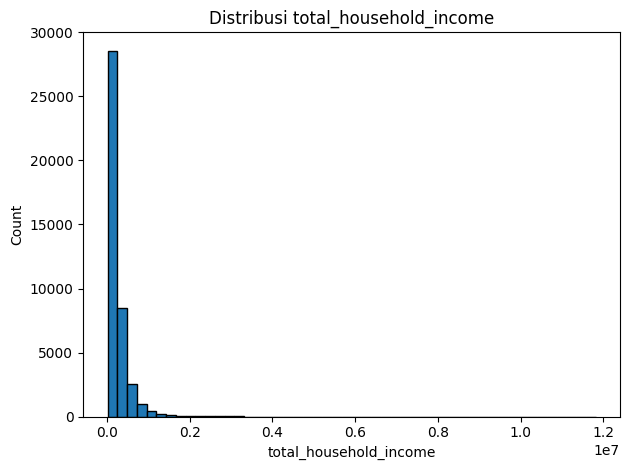

In [11]:
# 7.1 Histogram untuk kolom income terpilih
if primary_income_col is not None and primary_income_col in df.columns:
    plt.figure()
    pd.to_numeric(df[primary_income_col], errors="coerce").dropna().plot(kind="hist", bins=50, edgecolor="black")
    plt.title(f"Distribusi {primary_income_col}")
    plt.xlabel(primary_income_col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

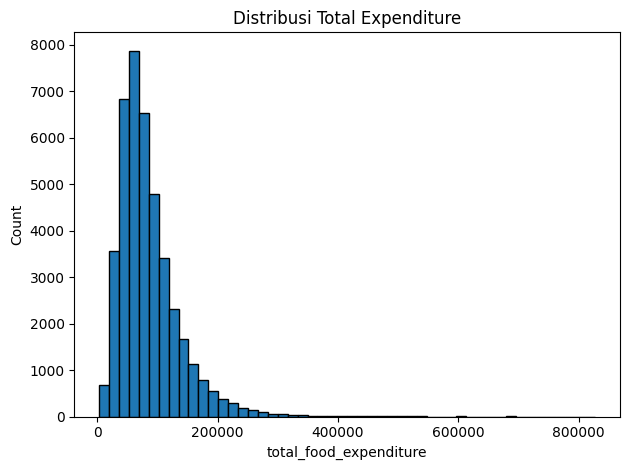

Statistik deskriptif Total Expenditure:
count    41,544.00
mean     85,099.16
std      51,637.95
min       2,947.00
25%      51,017.25
50%      72,985.50
75%     105,635.50
90%     148,255.20
95%     181,990.60
99%     263,676.09
max     827,565.00
Name: total_food_expenditure, dtype: float64


In [12]:
# 7.2 Histogram total pengeluaran

total_exp_series = pd.to_numeric(df[total_expenditure_col], errors="coerce")

plt.figure()
total_exp_series.dropna().plot(kind="hist", bins=50, edgecolor="black")
plt.title("Distribusi Total Expenditure")
plt.xlabel(total_expenditure_col)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Ringkasan statistik tambahan
print("Statistik deskriptif Total Expenditure:")
print(total_exp_series.describe(percentiles=[.25, .5, .75, .9, .95, .99]))

## 8) Komposisi Pengeluaran per Kategori (Nominal)
Tujuan: menemukan kategori dengan kontribusi nominal terbesar.  
Metode: menghitung rata-rata nominal pada setiap kolom pengeluaran, kemudian menampilkan 10 kategori teratas.

In [13]:
exp_df = df[exp_cols].apply(pd.to_numeric, errors="coerce")

summary = pd.DataFrame({
    "mean": exp_df.mean(),
    "median": exp_df.median(),
    "std": exp_df.std(ddof=1),
    "min": exp_df.min(),
    "max": exp_df.max(),
    "p90": exp_df.quantile(0.90),
    "p95": exp_df.quantile(0.95),
    "p99": exp_df.quantile(0.99),
    "missing_cnt": exp_df.isna().sum(),
    "missing_pct": (exp_df.isna().mean() * 100).round(2)
}).sort_values("mean", ascending=False)

print("Ringkasan Statistik Kategori Pengeluaran (diurutkan menurut mean)")
display(summary.head(10))

Ringkasan Statistik Kategori Pengeluaran (diurutkan menurut mean)


,mean,median,std,min,max,p90,p95,p99,missing_cnt,missing_pct
total_food_expenditure,"85,099.16","72,985.50","51,637.95",2947,827565,"148,255.20","181,990.60","263,676.09",0,0.00
housing_and_water_expenditure,"38,375.47","22,992.00","53,111.68",1950,2188560,"80,520.00","114,210.00","221,256.78",0,0.00
bread_and_cereals_expenditure,"25,133.72","23,324.00","13,466.48",0,765864,"40,384.70","46,887.00","63,547.41",0,0.00
total_rice_expenditure,"18,195.83","16,620.00","11,727.22",0,758326,"31,481.10","36,939.70","50,204.56",0,0.00
restaurant_and_hotels_expenditure,"15,436.57","7,314.00","23,705.20",0,725296,"39,628.90","57,063.60","106,229.90",0,0.00
crop_farming_and_gardening_expenses,"13,816.86",0.00,"47,643.78",0,3729973,"45,112.80","78,204.55","164,896.67",0,0.00
miscellaneous_goods_and_services_expenditure,"12,522.07","6,804.00","17,547.03",0,553560,"28,816.20","41,795.10","82,152.84",0,0.00
transportation_expenditure,"11,806.34","6,036.00","19,351.21",0,834996,"27,492.00","41,026.20","86,352.84",0,0.00
meat_expenditure,"10,540.07","7,332.50","10,497.73",0,261566,"23,696.70","30,950.65","48,145.57",0,0.00
total_fish_and_marine_products_expenditure,"10,529.32","8,695.00","7,812.20",0,188208,"19,430.70","24,490.00","38,945.85",0,0.00


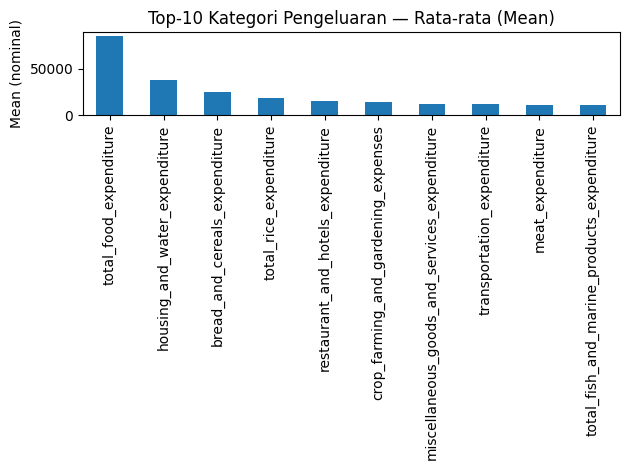

In [14]:
# Top-10 kategori berdasarkan mean
top10_mean = summary.sort_values("mean", ascending=False).head(10)["mean"]

plt.figure()
top10_mean.plot(kind="bar")
plt.title("Top-10 Kategori Pengeluaran — Rata-rata (Mean)")
plt.ylabel("Mean (nominal)")
plt.tight_layout()
plt.show()

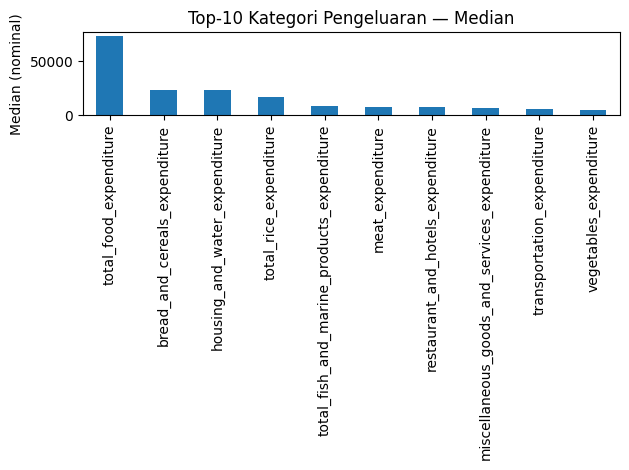

In [15]:
# Top-10 kategori berdasarkan median (lebih robust terhadap outlier)
top10_median = summary.sort_values("median", ascending=False).head(10)["median"]

plt.figure()
top10_median.plot(kind="bar")
plt.title("Top-10 Kategori Pengeluaran — Median")
plt.ylabel("Median (nominal)")
plt.tight_layout()
plt.show()

## 9) Hubungan Pendapatan vs Pengeluaran Untuk Makanan
Tujuan: memahami korelasi makro antara pendapatan dan pengeluaran.  
- Jika titik berada jauh di atas garis `y = x`, terdapat indikasi **overspending**.  
- Tingkat overspending dihitung dengan membandingkan estimasi total pengeluaran dengan pendapatan utama per baris (hitung sementara, tidak membuat kolom baru).

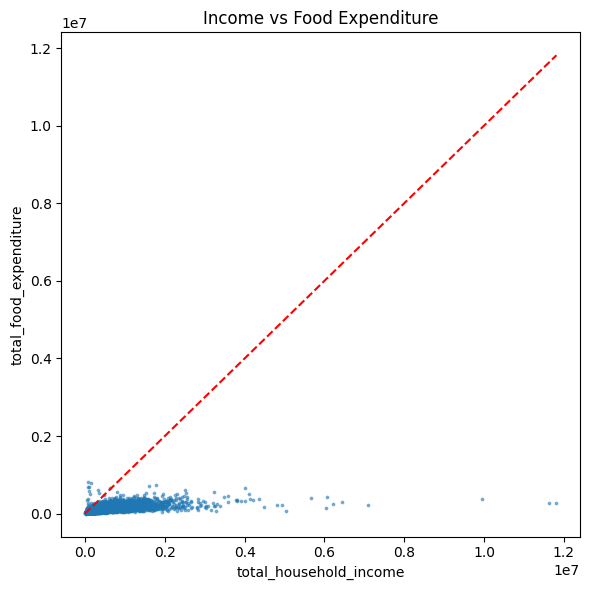

Persentase overspending (pengeluaran > pendapatan): 0.75%


In [16]:
income_s = pd.to_numeric(df[primary_income_col], errors="coerce")
spend_s = pd.to_numeric(df[total_expenditure_col], errors="coerce")

valid_mask = income_s.notna() & spend_s.notna()
x = income_s[valid_mask]
y = spend_s[valid_mask]

plt.figure(figsize=(6,6))
plt.scatter(x, y, s=3, alpha=0.5)
max_axis = max(x.max(), y.max())
plt.plot([0, max_axis], [0, max_axis], color="red", linestyle="--")  # garis y = x
plt.title("Income vs Food Expenditure")
plt.xlabel(primary_income_col)
plt.ylabel(total_expenditure_col)
plt.tight_layout()
plt.show()

overspend_rate = (y > x).mean() * 100
print(f"Persentase overspending (pengeluaran > pendapatan): {overspend_rate:.2f}%")

## 10) Perbedaan Pola Pengeluaran per Kuartil Pendapatan (Sementara)
Tujuan: memeriksa apakah proporsi kategori pengeluaran berubah seiring naiknya pendapatan (indikasi hukum Engel).  
Langkah:
- Membentuk kuartil pendapatan dari `primary_income_col` (sementara).  
- Menghitung **proporsi sementara** per kategori = `kategori / total pengeluaran` (jika total pengeluaran tersedia atau bisa dihitung).  
- Menampilkan rata-rata proporsi pada **bucket kategori** yang umum digunakan dalam budgeting: **Primer, Sekunder, Tersier**.

Catatan: perhitungan dilakukan secara **sementara** (tanpa menambah kolom ke `df`).

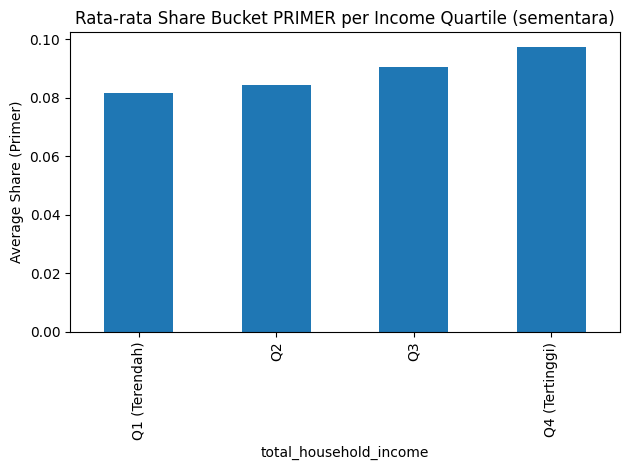

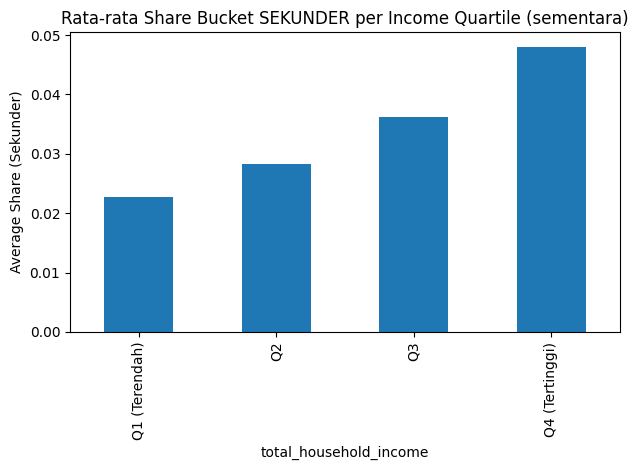

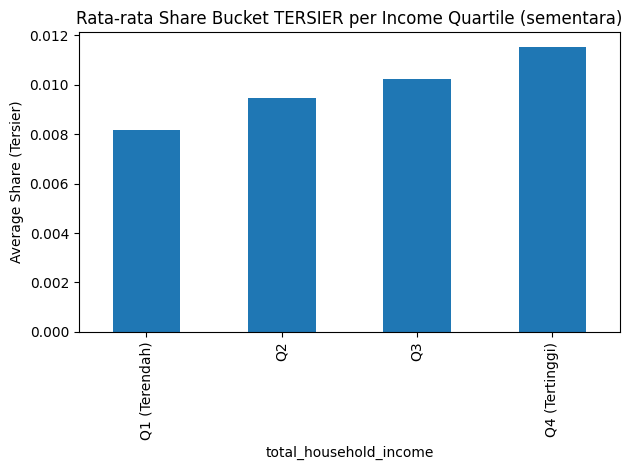

In [17]:
# Definisi bucket kategori (gunakan hanya yang ada di dataset)
primer = [
    "total_food_expenditure",
    "housing_and_water_expenditure",
    "transportation_expenditure",
    "communication_expenditure",
    "medical_care_expenditure",
    "education_expenditure",
]
sekunder = [
    "clothing_footwear_and_other_wear_expenditure",
    "restaurant_and_hotels_expenditure",
    "miscellaneous_goods_and_services_expenditure",
]
tersier = [
    "alcoholic_beverages_expenditure",
    "tobacco_expenditure",
    "special_occasions_expenditure",
]

def existing_columns(cols):
    return [c for c in cols if c in df.columns]

# Income quartiles (sementara)
income_s = pd.to_numeric(df[primary_income_col], errors="coerce")
valid_income = income_s.dropna()
if len(valid_income) >= 4:
    q_labels = ["Q1 (Terendah)", "Q2", "Q3", "Q4 (Tertinggi)"]
    income_quartile = pd.qcut(valid_income, q=4, labels=q_labels)
    quartile_aligned = income_quartile.reindex(df.index)

# Hitung proporsi sementara untuk setiap kategori pengeluaran yang tersedia
exp_df = df[[c for c in exp_cols if c in df.columns]].apply(pd.to_numeric, errors="coerce").fillna(0)
total_exp_tmp = exp_df.sum(axis=1)
with np.errstate(divide='ignore', invalid='ignore'):
    share_tmp = exp_df.div(total_exp_tmp.replace(0, np.nan), axis=0).fillna(0)

# Rata-rata share per bucket per kuartil
def average_bucket_share(share_frame, bucket_cols, quartile_series):
    cols_exist = [c for c in bucket_cols if c in share_frame.columns]
    if not cols_exist:
        return None
    grp = share_frame[cols_exist].groupby(quartile_series).mean()
    return grp.mean(axis=1)

avg_primer = average_bucket_share(share_tmp, existing_columns(primer), quartile_aligned)
avg_sekunder = average_bucket_share(share_tmp, existing_columns(sekunder), quartile_aligned)
avg_tersier = average_bucket_share(share_tmp, existing_columns(tersier), quartile_aligned)

plt.figure()
avg_primer.plot(kind="bar")
plt.title("Rata-rata Share Bucket PRIMER per Income Quartile (sementara)")
plt.ylabel("Average Share (Primer)")
plt.tight_layout()
plt.show()

plt.figure()
avg_sekunder.plot(kind="bar")
plt.title("Rata-rata Share Bucket SEKUNDER per Income Quartile (sementara)")
plt.ylabel("Average Share (Sekunder)")
plt.tight_layout()
plt.show()

plt.figure()
avg_tersier.plot(kind="bar")
plt.title("Rata-rata Share Bucket TERSIER per Income Quartile (sementara)")
plt.ylabel("Average Share (Tersier)")
plt.tight_layout()
plt.show()

## 11) Korelasi Antar Kategori Pengeluaran (Proporsi Sementara)
Tujuan: mengamati hubungan substitusi/komplementer antar kategori melalui korelasi proporsi (dihitung sementara).  
Langkah: membentuk matriks proporsi kategori (`kategori / total pengeluaran`) secara sementara, lalu menghitung korelasi.

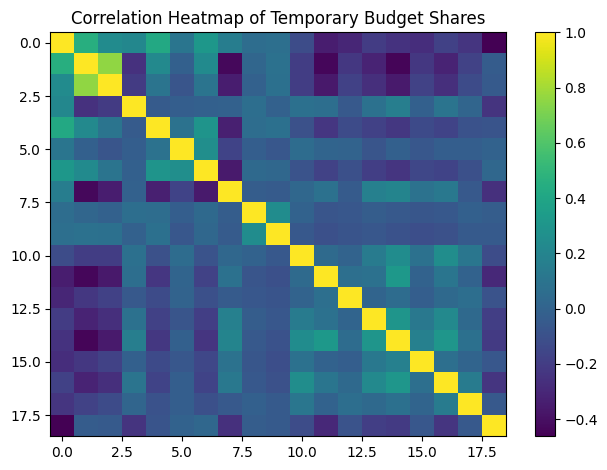

In [18]:
exp_df = df[exp_cols].apply(pd.to_numeric, errors="coerce").fillna(0)
total_exp_tmp = exp_df.sum(axis=1)
with np.errstate(divide='ignore', invalid='ignore'):
    share_tmp = exp_df.div(total_exp_tmp.replace(0, np.nan), axis=0).fillna(0)

corr = share_tmp.corr()
plt.figure()
plt.imshow(corr, aspect="auto", interpolation="nearest")
plt.title("Correlation Heatmap of Temporary Budget Shares")
plt.colorbar()
plt.tight_layout()
plt.show()

In [19]:
# Baca beberapa baris awal dataset untuk melihat struktur kolom
df2 = df.copy()
print(df2.columns.tolist())
print(df2.head(5))

['total_household_income', 'region', 'total_food_expenditure', 'main_source_of_income', 'agricultural_household_indicator', 'bread_and_cereals_expenditure', 'total_rice_expenditure', 'meat_expenditure', 'total_fish_and_marine_products_expenditure', 'fruit_expenditure', 'vegetables_expenditure', 'restaurant_and_hotels_expenditure', 'alcoholic_beverages_expenditure', 'tobacco_expenditure', 'clothing_footwear_and_other_wear_expenditure', 'housing_and_water_expenditure', 'imputed_house_rental_value', 'medical_care_expenditure', 'transportation_expenditure', 'communication_expenditure', 'education_expenditure', 'miscellaneous_goods_and_services_expenditure', 'special_occasions_expenditure', 'crop_farming_and_gardening_expenses', 'total_income_from_entrepreneurial_acitivites', 'household_head_sex', 'household_head_age', 'household_head_marital_status', 'household_head_highest_grade_completed', 'household_head_job_or_business_indicator', 'household_head_occupation', 'household_head_class_of_w

In [20]:
# Selection columns based on the original dataset

# Load dataset in chunks to filter by region NCR
use_cols = ['Total Household Income', 'Region', 'Total Number of Family members',
            'Number of Car, Jeep, Van', 'Number of Motorcycle/Tricycle',
            'Total Food Expenditure', 'Transportation Expenditure', 'Housing and water Expenditure',
            'Medical Care Expenditure', 'Communication Expenditure',
            'Education Expenditure', 'Clothing, Footwear and Other Wear Expenditure',
            'Alcoholic Beverages Expenditure', 'Tobacco Expenditure',
            'Miscellaneous Goods and Services Expenditure', 'Special Occasions Expenditure']
            
chunks = pd.read_csv('Family Income and Expenditure.csv', usecols=use_cols, chunksize=10000)
df_list = []
for chunk in chunks:
    # Filter region NCR only
    df_ncr = chunk[chunk['Region'] == 'NCR']
    if len(df_ncr) > 0:
        df_list.append(df_ncr)
df_ncr = pd.concat(df_list, ignore_index=True)

# Create feature for total vehicles owned (cars + motorcycles)
df_ncr['Total Vehicles'] = df_ncr['Number of Car, Jeep, Van'] + df_ncr['Number of Motorcycle/Tricycle']

# Create "Others" expenditure as sum of various other expense columns
df_ncr['Others Expenditure'] = (df_ncr['Education Expenditure'].fillna(0) +
                                df_ncr['Clothing, Footwear and Other Wear Expenditure'].fillna(0) +
                                df_ncr['Alcoholic Beverages Expenditure'].fillna(0) +
                                df_ncr['Tobacco Expenditure'].fillna(0) +
                                df_ncr['Miscellaneous Goods and Services Expenditure'].fillna(0) +
                                df_ncr['Special Occasions Expenditure'].fillna(0))
                                
# Select final features and targets
features = df_ncr[['Total Household Income', 'Total Number of Family members', 'Total Vehicles']]
targets  = df_ncr[['Total Food Expenditure', 'Transportation Expenditure', 'Housing and water Expenditure',
                   'Medical Care Expenditure', 'Communication Expenditure', 'Others Expenditure']]

# Adjust values for inflation to 2025 (assuming ~30% increase from data year to 2025)
inflation_factor = 1.3
features['Total Household Income'] *= inflation_factor
targets = targets * inflation_factor

In [21]:
# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 3304, Testing samples: 826


In [22]:
# Build layer model using TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import warnings
warnings.filterwarnings("ignore")

# Definisikan arsitektur model
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    # layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # input layer (3 fitur)
    # layers.Dense(32, activation='relu'),
    # layers.Dense(16, activation='relu'),
    layers.Dense(y_train.shape[1], activation='linear')  # output layer (6 output, linear activation)
])

model.compile(optimizer='adam', loss='mse')  # menggunakan Mean Squared Error
model.summary()

I0000 00:00:1761500130.781680   55036 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-27 00:35:30.804695: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,246 (180.65 KB)

 Trainable params: 45,350 (177.15 KB)

 Non-trainable params: 896 (3.50 KB)

In [23]:
# Training model
# Callbacks
callbacks_list = [
    callbacks.EarlyStopping(patience=8, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7)
]
# Melatih model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=128,
    callbacks=callbacks_list,
    verbose=1  # set verbose=1 untuk melihat progress
)

# Save the trained Keras model to models folder
model_save_path = 'models/budget_keras_model.keras'
os.makedirs('models', exist_ok=True)
model.save(model_save_path)
print(f"\n✓ Keras model saved to {model_save_path}")

Epoch 1/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 14130969600.0000 - val_loss: 14057537536.0000 - learning_rate: 0.0010
Epoch 2/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14130481152.0000 - val_loss: 14056168448.0000 - learning_rate: 0.0010
Epoch 3/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14129593344.0000 - val_loss: 14054856704.0000 - learning_rate: 0.0010
Epoch 4/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14128016384.0000 - val_loss: 14052370432.0000 - learning_rate: 0.0010
Epoch 5/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14125488128.0000 - val_loss: 14048910336.0000 - learning_rate: 0.0010
Epoch 6/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14121865216.0000 - val_loss: 14044041216.0000 - learning_rate: 0.0010
Epoch 7/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14116742144.0000 - val_loss: 14038918144.0000 - learning_rate: 0.0010
Epoch 8/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14110092288.0000 - val_loss: 14033612

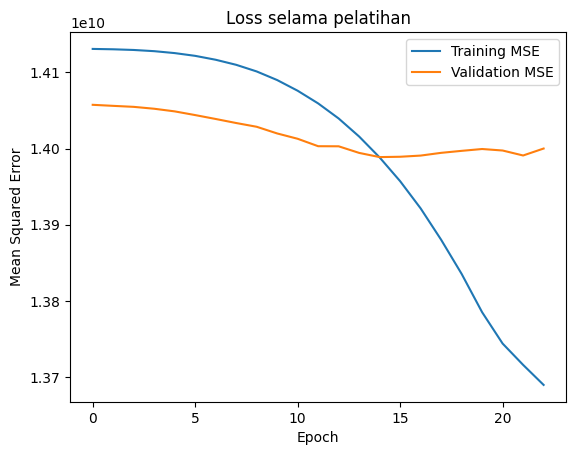

MSE on test data: 13988837376.00


In [24]:
# evaluasi model
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.title('Loss selama pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Evaluasi akhir pada data uji
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"MSE on test data: {test_loss:.2f}")

In [25]:
# Ambil satu sampel data uji dan lihat prediksi model vs aktual
sample = X_test.iloc[[0]]
actual = y_test.iloc[0]
prediction = model.predict(sample)[0]

print("Input features:")
print(sample)
print("\nPredicted expenditures (Food, Transport, Housing, Health, Comm, Others):")
print(prediction)
print("Actual expenditures:")
print(actual.values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Input features:
      Total Household Income  Total Number of Family members  Total Vehicles
1864              542,617.40                               3               0

Predicted expenditures (Food, Transport, Housing, Health, Comm, Others):
[165.88454  136.47568   80.811676 145.30426   97.37588   84.9196  ]
Actual expenditures:
[121205.5  26785.2  90160.2   2538.9   1349.4  23510.5]


In [26]:
## 12) Web Scraping Inflasi BPS Indonesia (Month-to-Month)

# Fungsi untuk scraping inflasi dari BPS
def scrape_bps_inflation(urls, save_to_csv=True):
    """
    Scrape inflation data from BPS website URLs
    
    Args:
        urls: List of BPS URLs to scrape
        save_to_csv: Whether to save results to CSV
        
    Returns:
        DataFrame with inflation data
    """
    inflation_data = []
    
    # Headers to mimic browser
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    for url in urls:
        try:
            print(f"Scraping: {url}")
            response = requests.get(url, headers=headers, timeout=10)
            
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                
                # Extract date from URL or content
                date_match = re.search(r'(\d{4})/(\d{2})/(\d{2})', url)
                if date_match:
                    year, month, day = date_match.groups()
                    date_obj = datetime(int(year), int(month), int(day))
                else:
                    # Try to extract from page content or title
                    title_tag = soup.find('title')
                    if title_tag:
                        title_text = title_tag.get_text().lower()
                        # Look for month names in Indonesian or English
                        months = ['januari', 'februari', 'maret', 'april', 'mei', 'juni', 'juli', 
                                 'agustus', 'september', 'oktober', 'november', 'desember',
                                 'january', 'february', 'march', 'april', 'may', 'june', 'july',
                                 'august', 'september', 'october', 'november', 'december']
                        for i, month_name in enumerate(months[:12], 1):
                            if month_name in title_text:
                                # Extract year from title
                                year_match = re.search(r'(\d{4})', title_text)
                                year = int(year_match.group(1)) if year_match else datetime.now().year
                                date_obj = datetime(year, i, 1)
                                break
                        else:
                            date_obj = datetime.now()
                    else:
                        date_obj = datetime.now()
                
                # Look for both YoY and MoM inflation
                content_text = soup.get_text()
                
                # Updated patterns for month-to-month (mtm) inflation - optimized for BPS format
                mtm_patterns = [
                    r'month[-\s]?to[-\s]?month.*?sebesar\s+(\d+,\d+)\s*persen',
                    r'm[-\s]?to[-\s]?m.*?sebesar\s+(\d+,\d+)\s*persen',
                    r'\(m[-\s]?to[-\s]?m\).*?sebesar\s+(\d+,\d+)\s*persen',
                    r'month[-\s]?to[-\s]?month.*?(\d+,\d+)\s*persen',
                    r'mtm.*?(\d+,\d+)\s*persen',
                    r'bulan[-\s]?ke[-\s]?bulan.*?(\d+,\d+)\s*persen',
                    r'bulanan.*?(\d+,\d+)\s*persen',
                    r'm\.t\.m.*?(\d+,\d+)\s*persen'
                ]
                
                # Updated patterns for year-on-year (yoy) inflation - optimized for BPS format
                yoy_patterns = [
                    r'year[-\s]?on[-\s]?year.*?sebesar\s+(\d+,\d+)\s*persen',
                    r'y[-\s]?on[-\s]?y.*?sebesar\s+(\d+,\d+)\s*persen',
                    r'\(y[-\s]?on[-\s]?y\).*?sebesar\s+(\d+,\d+)\s*persen',
                    r'year[-\s]?on[-\s]?year.*?(\d+,\d+)\s*persen',
                    r'yoy.*?(\d+,\d+)\s*persen',
                    r'tahun[-\s]?ke[-\s]?tahun.*?(\d+,\d+)\s*persen',
                    r'tahunan.*?(\d+,\d+)\s*persen',
                    r'y\.o\.y.*?(\d+,\d+)\s*persen'
                ]
                
                # Additional pattern for year-to-date (ytd) inflation
                ytd_patterns = [
                    r'year[-\s]?to[-\s]?date.*?sebesar\s+(\d+,\d+)\s*persen',
                    r'y[-\s]?to[-\s]?d.*?sebesar\s+(\d+,\d+)\s*persen',
                    r'\(y[-\s]?to[-\s]?d\).*?sebesar\s+(\d+,\d+)\s*persen',
                    r'year[-\s]?to[-\s]?date.*?(\d+,\d+)\s*persen',
                    r'ytd.*?(\d+,\d+)\s*persen'
                ]
                
                mtm_value = None
                yoy_value = None
                
                # Extract month-to-month inflation
                for pattern in mtm_patterns:
                    match = re.search(pattern, content_text, re.IGNORECASE)
                    if match:
                        value_str = match.group(1)
                        value_str = value_str.replace(',', '.')
                        try:
                            mtm_value = float(value_str)
                            break
                        except:
                            continue
                
                # Extract year-on-year inflation
                for pattern in yoy_patterns:
                    match = re.search(pattern, content_text, re.IGNORECASE)
                    if match:
                        value_str = match.group(1)
                        value_str = value_str.replace(',', '.')
                        try:
                            yoy_value = float(value_str)
                            break
                        except:
                            continue
                
                # If YoY not found, try to use YtD as fallback
                if yoy_value is None:
                    for pattern in ytd_patterns:
                        match = re.search(pattern, content_text, re.IGNORECASE)
                        if match:
                            value_str = match.group(1)
                            value_str = value_str.replace(',', '.')
                            try:
                                yoy_value = float(value_str)
                                print(f"  Using YtD as YoY fallback: {yoy_value}%")
                                break
                            except:
                                continue
                
                # If not found in text, try to extract from tables
                if mtm_value is None or yoy_value is None:
                    tables = soup.find_all('table')
                    for table in tables:
                        table_text = table.get_text()
                        if 'inflasi' in table_text.lower():
                            # Look for all percentage values in table
                            percentages = re.findall(r'(\d+,\d+|\d+\.\d+)\s*%?', table_text)
                            if percentages:
                                # First is usually MoM, second is YoY based on BPS format
                                for i, value_str in enumerate(percentages[:2]):
                                    value_str = value_str.replace(',', '.')
                                    try:
                                        value = float(value_str)
                                        if i == 0 and mtm_value is None:
                                            mtm_value = value
                                        elif i == 1 and yoy_value is None:
                                            yoy_value = value
                                    except:
                                        continue
                
                # Store the data
                if mtm_value is not None or yoy_value is not None:
                    inflation_data.append({
                        'date': date_obj.strftime('%Y-%m-%d'),
                        'year': date_obj.year,
                        'month': date_obj.month,
                        'inflation_mom': mtm_value if mtm_value is not None else 0.0,
                        'inflation_yoy': yoy_value if yoy_value is not None else 0.0,
                        'source_url': url
                    })
                    print(f"✓ Found MoM: {mtm_value}%, YoY: {yoy_value}% for {date_obj.strftime('%Y-%m')}")
                else:
                    print(f"✗ Could not extract inflation rates from {url}")
                    
            else:
                print(f"✗ Failed to fetch {url}, status code: {response.status_code}")
                
        except Exception as e:
            print(f"✗ Error scraping {url}: {str(e)}")
    
    # Create DataFrame
    print("\nProcessing scraped data...")
    if inflation_data:
        df_inflation = pd.DataFrame(inflation_data)
        df_inflation = df_inflation.sort_values('date').reset_index(drop=True)
        
        # Fill missing values with forward fill
        df_inflation['inflation_mom'] = df_inflation['inflation_mom'].replace(0, np.nan).fillna(method='ffill').fillna(0)
        df_inflation['inflation_yoy'] = df_inflation['inflation_yoy'].replace(0, np.nan).fillna(method='ffill').fillna(0)
        
        # Calculate monthly inflation factor
        df_inflation['monthly_factor'] = 1 + (df_inflation['inflation_mom'] / 100)
        
        # Save to CSV if requested
        if save_to_csv:
            df_inflation.to_csv('bps_inflation_data.csv', index=False)
            print(f"✓ Saved inflation data to bps_inflation_data.csv")
        
        return df_inflation
    else:
        print("✗ No inflation data was successfully scraped")
        return None

# URLs untuk scraping inflasi BPS
inflation_urls = [
    f"https://www.bps.go.id/id/pressrelease/2025/10/01/2468/inflasi-year-on-year--y-on-y--pada-september-2025-sebesar-2-65-persen.html",
    f"https://www.bps.go.id/id/pressrelease/2025/01/02/2397/pasa-desember-2024-inflasi-year-on-year%E2%80%94y-o-y%E2%80%94adalah-sebesar-1-57-persen-.html",
    "https://www.bps.go.id/id/pressrelease"
]

# Fungsi untuk load inflation data dari CSV jika sudah ada
def load_inflation_data(csv_path='bps_inflation_data.csv'):
    """Load inflation data from CSV file if it exists"""
    if os.path.exists(csv_path):
        print(f"Loading inflation data from {csv_path}")
        df = pd.read_csv(csv_path)
        df['date'] = pd.to_datetime(df['date'])
        return df
    else:
        print(f"No existing inflation data found at {csv_path}")
        return None

# Check if we already have inflation data
inflation_df = load_inflation_data()

# If no existing data, scrape from BPS
if inflation_df is None:
    print("Scraping inflation data from BPS...")
    inflation_df = scrape_bps_inflation(inflation_urls)

# Display the inflation data if available
if inflation_df is not None:
    print("\n=== Inflation Data Summary ===")
    print(inflation_df[['date', 'inflation_mom', 'inflation_yoy']].head(12))
    
    # Plot inflation trends
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(inflation_df['date'], inflation_df['inflation_mom'], marker='o', linewidth=2, label='Month-to-Month', color='blue')
    plt.title('Indonesia Month-to-Month Inflation Rate (BPS Data)', fontsize=14, fontweight='bold')
    plt.ylabel('Inflation Rate (%)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.subplot(2, 1, 2)
    plt.plot(inflation_df['date'], inflation_df['inflation_yoy'], marker='s', linewidth=2, label='Year-to-Year', color='red')
    plt.title('Indonesia Year-to-Year Inflation Rate (BPS Data)', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Inflation Rate (%)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Get latest inflation for model use
    latest_mom = inflation_df.iloc[-1]['inflation_mom']
    latest_yoy = inflation_df.iloc[-1]['inflation_yoy']
    print(f"\nLatest month-to-month inflation: {latest_mom}%")
    print(f"Latest year-to-year inflation: {latest_yoy}%")
else:
    # Fallback: use default inflation assumption
    latest_mom = 0.21  # Default monthly inflation (2.5% annual)
    latest_yoy = 2.5
    print(f"Using default inflation rates: MoM={latest_mom}%, YoY={latest_yoy}%")

No existing inflation data found at bps_inflation_data.csv
Scraping inflation data from BPS...
Scraping: https://www.bps.go.id/id/pressrelease/2025/10/01/2468/inflasi-year-on-year--y-on-y--pada-september-2025-sebesar-2-65-persen.html
✗ Failed to fetch https://www.bps.go.id/id/pressrelease/2025/10/01/2468/inflasi-year-on-year--y-on-y--pada-september-2025-sebesar-2-65-persen.html, status code: 403
Scraping: https://www.bps.go.id/id/pressrelease/2025/01/02/2397/pasa-desember-2024-inflasi-year-on-year%E2%80%94y-o-y%E2%80%94adalah-sebesar-1-57-persen-.html
✗ Failed to fetch https://www.bps.go.id/id/pressrelease/2025/01/02/2397/pasa-desember-2024-inflasi-year-on-year%E2%80%94y-o-y%E2%80%94adalah-sebesar-1-57-persen-.html, status code: 403
Scraping: https://www.bps.go.id/id/pressrelease
✗ Failed to fetch https://www.bps.go.id/id/pressrelease, status code: 403

Processing scraped data...
✗ No inflation data was successfully scraped
Using default inflation rates: MoM=0.21%, YoY=2.5%


In [27]:
## 13) Data Preparation dengan Kategori Primer/Sekunder/Tersier

# Definisi kategori pengeluaran berdasarkan permintaan
primer = [
    "total_food_expenditure",
    "housing_and_water_expenditure", 
    "transportation_expenditure",
    "communication_expenditure",
    "medical_care_expenditure",
    "education_expenditure",
]

sekunder = [
    "clothing_footwear_and_other_wear_expenditure",
    "restaurant_and_hotels_expenditure",
    "miscellaneous_goods_and_services_expenditure",
]

tersier = [
    "alcoholic_beverages_expenditure",
    "tobacco_expenditure",
    "special_occasions_expenditure",
]

# Load dan prepare data dengan semua kategori
def prepare_complete_dataset(df, inflation_factor=1.3):
    """Prepare dataset with all expenditure categories"""
    
    # Convert column names to snake_case if not already
    if not all('_' in col for col in df.columns):
        df.columns = [to_snake(col) for col in df.columns]
    
    # Filter for NCR region (or use all data if NCR not found)
    if 'region' in df.columns:
        if 'NCR' in df['region'].values:
            df = df[df['region'] == 'NCR'].copy()
        else:
            print("Region NCR not found, using all data")
    
    # Apply inflation adjustment
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if 'income' in col.lower() or 'expenditure' in col.lower() or 'expenses' in col.lower():
            df[col] = df[col] * inflation_factor
    
    # Create features with consistent column order
    features = pd.DataFrame()
    
    # Main income feature
    income_cols = [c for c in df.columns if 'income' in c.lower() and 'total' in c.lower()]
    if income_cols:
        features['total_income'] = pd.to_numeric(df[income_cols[0]], errors='coerce').fillna(df[income_cols[0]].median())
    else:
        # Use first income column found
        income_cols = [c for c in df.columns if 'income' in c.lower()]
        if income_cols:
            features['total_income'] = pd.to_numeric(df[income_cols[0]], errors='coerce').fillna(df[income_cols[0]].median())
    
    # Family members
    if 'total_number_of_family_members' in df.columns:
        features['family_size'] = pd.to_numeric(df['total_number_of_family_members'], errors='coerce').fillna(1)
    elif 'family_members' in df.columns:
        features['family_size'] = pd.to_numeric(df['family_members'], errors='coerce').fillna(1)
    else:
        features['family_size'] = 4  # Default
    
    # Vehicles
    vehicle_cols = [c for c in df.columns if 'car' in c.lower() or 'motorcycle' in c.lower() or 'vehicle' in c.lower()]
    if vehicle_cols:
        features['total_vehicles'] = df[vehicle_cols].apply(pd.to_numeric, errors='coerce').sum(axis=1).fillna(0)
    else:
        features['total_vehicles'] = 0
    
    # Region encoding (if available)
    if 'region' in df.columns:
        features['region_encoded'] = df['region'].astype('category').cat.codes
    else:
        features['region_encoded'] = 0
    
    # Add derived features
    features['income_per_capita'] = features['total_income'] / features['family_size']
    features['vehicles_per_capita'] = features['total_vehicles'] / features['family_size']
    
    # Define the feature order and keep it consistent
    feature_order = [
        'total_income',
        'family_size', 
        'total_vehicles',
        'income_per_capita',
        'vehicles_per_capita',
        'region_encoded'
    ]
    
    # Ensure all columns exist and reorder
    for col in feature_order:
        if col not in features.columns:
            features[col] = 0  # Default value if missing
    
    features = features[feature_order]
    
    # Create targets dictionary for all categories
    targets = pd.DataFrame(index=df.index)
    
    # Helper function to find expenditure column
    def find_expenditure_col(keywords):
        for col in df.columns:
            if any(keyword in col.lower() for keyword in keywords):
                return col
        return None
    
    # Primer categories
    primer_mapping = {
        'total_food_expenditure': ['food'],
        'housing_and_water_expenditure': ['housing', 'water'],
        'transportation_expenditure': ['transport'],
        'communication_expenditure': ['communication'],
        'medical_care_expenditure': ['medical', 'health'],
        'education_expenditure': ['education']
    }
    
    for target_col, keywords in primer_mapping.items():
        source_col = find_expenditure_col(keywords)
        if source_col:
            targets[target_col] = pd.to_numeric(df[source_col], errors='coerce').fillna(0)
        else:
            targets[target_col] = 0
            print(f"Warning: Could not find column for {target_col}")
    
    # Sekunder categories  
    sekunder_mapping = {
        'clothing_footwear_and_other_wear_expenditure': ['clothing', 'footwear'],
        'restaurant_and_hotels_expenditure': ['restaurant', 'hotel'],
        'miscellaneous_goods_and_services_expenditure': ['miscellaneous']
    }
    
    for target_col, keywords in sekunder_mapping.items():
        source_col = find_expenditure_col(keywords)
        if source_col:
            targets[target_col] = pd.to_numeric(df[source_col], errors='coerce').fillna(0)
        else:
            targets[target_col] = 0
            print(f"Warning: Could not find column for {target_col}")
    
    # Tersier categories
    tersier_mapping = {
        'alcoholic_beverages_expenditure': ['alcoholic'],
        'tobacco_expenditure': ['tobacco'],
        'special_occasions_expenditure': ['special occasions']
    }
    
    for target_col, keywords in tersier_mapping.items():
        source_col = find_expenditure_col(keywords)
        if source_col:
            targets[target_col] = pd.to_numeric(df[source_col], errors='coerce').fillna(0)
        else:
            targets[target_col] = 0
            print(f"Warning: Could not find column for {target_col}")
    
    # Calculate category totals
    targets['primer_total'] = targets[primer].sum(axis=1)
    targets['sekunder_total'] = targets[sekunder].sum(axis=1)
    targets['tersier_total'] = targets[tersier].sum(axis=1)
    targets['grand_total'] = targets.sum(axis=1)
    
    return features, targets, feature_order

# Prepare the complete dataset
print("Preparing complete dataset with all categories...")
X_complete, y_complete, feature_columns = prepare_complete_dataset(df, inflation_factor=1.3)

# Remove any rows with all zero expenditures
valid_mask = y_complete['grand_total'] > 0
X_complete = X_complete[valid_mask]
y_complete = y_complete[valid_mask]

print(f"Feature columns order: {feature_columns}")
print(f"Dataset shape after cleaning: {X_complete.shape}")
print(f"\nFeatures summary:")
print(X_complete.describe())
print(f"\nTarget categories summary:")
print(y_complete[primer + sekunder + tersier].describe())

Preparing complete dataset with all categories...
Feature columns order: ['total_income', 'family_size', 'total_vehicles', 'income_per_capita', 'vehicles_per_capita', 'region_encoded']
Dataset shape after cleaning: (4130, 6)

Features summary:
       total_income  family_size  total_vehicles  income_per_capita  vehicles_per_capita  region_encoded
count      4,130.00     4,130.00        4,130.00           4,130.00             4,130.00        4,130.00
mean     547,120.42         4.53       12,821.86         145,654.16             3,766.52            0.00
std      499,831.37         2.29       36,055.75         166,744.83            13,412.04            0.00
min       48,223.50         1.00            0.00          11,922.73                 0.00            0.00
25%      265,560.75         3.00        1,127.10          64,065.30               255.35            0.00
50%      405,957.50         4.00        3,517.00         100,831.14               863.95            0.00
75%      644,746.05  

Training set shape: (3304, 6)
Test set shape: (826, 6)
✓ Feature scaler saved to models/feature_scaler.pkl
Training XGBoost models for each expenditure category...

Training model for: total_food_expenditure
  RMSE: 45,716
  MAE: 32,349
  R²: 0.697
  Best params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}

Training model for: housing_and_water_expenditure
  RMSE: 102,687
  MAE: 45,717
  R²: 0.548
  Best params: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}

Training model for: transportation_expenditure
  RMSE: 42,510
  MAE: 16,019
  R²: 0.264
  Best params: {'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}

Training model for: communication_expenditure
  RMSE: 10,026
  MAE:

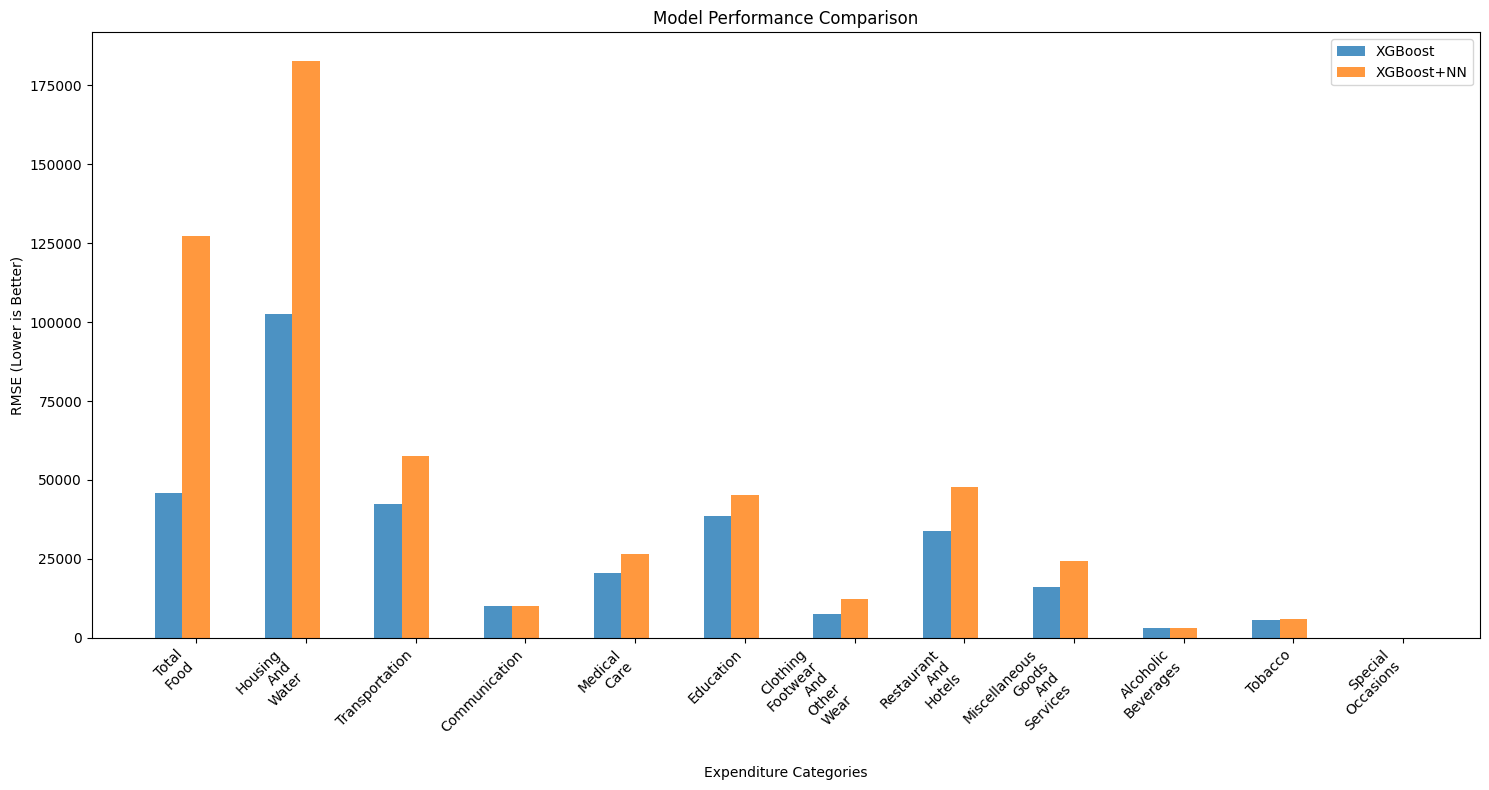

✓ XGBoost models saved to models/best_xgboost_models.pkl
✓ Ensemble models saved to models/best_ensemble_models.pkl


In [28]:
## 14) Optimized Model dengan XGBoost dan Hyperparameter Tuning

# Split data untuk training dan testing
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_complete, y_complete[primer + sekunder + tersier], 
    test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train_full.shape}")
print(f"Test set shape: {X_test_full.shape}")

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

# Save the scaler with feature names to models folder
os.makedirs('models', exist_ok=True)
scaler_data = {
    'scaler': scaler,
    'feature_names': feature_columns,
    'feature_order': feature_columns
}
joblib.dump(scaler_data, 'models/feature_scaler.pkl')
print("✓ Feature scaler saved to models/feature_scaler.pkl")

# 1. XGBoost Model dengan Hyperparameter Tuning
def train_xgboost_model(X_train, y_train, X_test, y_test):
    """Train XGBoost model with hyperparameter tuning"""
    
    # Hyperparameter grid
    param_grid = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [1, 1.5, 2]
    }
    
    models = {}
    predictions = {}
    metrics = {}
    
    print("Training XGBoost models for each expenditure category...")
    
    for category in primer + sekunder + tersier:
        print(f"\nTraining model for: {category}")
        
        # Initialize XGBoost regressor
        xgb_model = xgb.XGBRegressor(
            objective='reg:squarederror',
            random_state=42,
            n_jobs=-1
        )
        
        # RandomizedSearchCV for hyperparameter tuning
        random_search = RandomizedSearchCV(
            estimator=xgb_model,
            param_distributions=param_grid,
            n_iter=50,
            cv=3,
            scoring='neg_mean_squared_error',
            random_state=42,
            n_jobs=-1,
            verbose=0
        )
        
        # Fit the model
        random_search.fit(X_train, y_train[category])
        
        # Best model
        best_model = random_search.best_estimator_
        models[category] = best_model
        
        # Predictions
        y_pred = best_model.predict(X_test)
        predictions[category] = y_pred
        
        # Metrics
        mse = mean_squared_error(y_test[category], y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test[category], y_pred)
        r2 = r2_score(y_test[category], y_pred)
        
        metrics[category] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'best_params': random_search.best_params_
        }
        
        print(f"  RMSE: {rmse:,.0f}")
        print(f"  MAE: {mae:,.0f}")
        print(f"  R²: {r2:.3f}")
        print(f"  Best params: {random_search.best_params_}")
    
    return models, predictions, metrics

# Train XGBoost models
xgb_models, xgb_predictions, xgb_metrics = train_xgboost_model(
    X_train_scaled, y_train_full, X_test_scaled, y_test_full
)

# 2. Ensemble Model (XGBoost + Neural Network)
def create_ensemble_predictions(X_train, y_train, X_test, xgb_models):
    """Create ensemble predictions combining XGBoost and Neural Network"""
    
    # Get XGBoost predictions
    xgb_train_preds = pd.DataFrame(index=X_train_full.index)
    xgb_test_preds = pd.DataFrame(index=X_test_full.index)
    
    for category in primer + sekunder + tersier:
        xgb_train_preds[category] = xgb_models[category].predict(X_train)
        xgb_test_preds[category] = xgb_models[category].predict(X_test)
    
    # Train neural network to combine predictions
    ensemble_models = {}
    ensemble_preds = {}
    
    for category in primer + sekunder + tersier:
        # Neural network architecture
        model = models.Sequential([
            layers.Input(shape=(X_train.shape[1] + 1,)),  # Original features + XGBoost prediction
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='linear')
        ])
        
        model.compile(
            optimizer='adam',
            loss='mse',
            metrics=['mae']
        )
        
        # Prepare training data (original features + XGBoost predictions)
        X_train_ensemble = np.hstack([X_train, xgb_train_preds[category].values.reshape(-1, 1)])
        X_test_ensemble = np.hstack([X_test, xgb_test_preds[category].values.reshape(-1, 1)])
        
        # Callbacks
        callbacks_list = [
            callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7)
        ]
        
        # Train
        model.fit(
            X_train_ensemble, y_train[category],
            validation_split=0.2,
            epochs=100,
            batch_size=64,
            callbacks=callbacks_list,
            verbose=0
        )
        
        ensemble_models[category] = model
        ensemble_preds[category] = model.predict(X_test_ensemble).flatten()
        
        print(f"✓ Ensemble model trained for {category}")
    
    return ensemble_models, ensemble_preds, xgb_test_preds

# Create ensemble models
ensemble_models, ensemble_predictions, xgb_test_predictions = create_ensemble_predictions(
    X_train_scaled, y_train_full, X_test_scaled, xgb_models
)

# 3. Model Evaluation and Comparison
def compare_models(y_true, xgb_preds, ens_preds):
    """Compare XGBoost vs Ensemble performance"""
    
    comparison = pd.DataFrame()
    
    for category in primer + sekunder + tersier:
        # XGBoost metrics
        xgb_mse = mean_squared_error(y_true[category], xgb_preds[category])
        xgb_rmse = np.sqrt(xgb_mse)
        xgb_r2 = r2_score(y_true[category], xgb_preds[category])
        
        # Ensemble metrics
        ens_mse = mean_squared_error(y_true[category], ens_preds[category])
        ens_rmse = np.sqrt(ens_mse)
        ens_r2 = r2_score(y_true[category], ens_preds[category])
        
        comparison = pd.concat([comparison, pd.DataFrame({
            'Category': [category.replace('_expenditure', '').replace('_', ' ').title()],
            'XGBoost_RMSE': [xgb_rmse],
            'Ensemble_RMSE': [ens_rmse],
            'XGBoost_R2': [xgb_r2],
            'Ensemble_R2': [ens_r2],
            'Improvement_%': [((xgb_rmse - ens_rmse) / xgb_rmse * 100)]
        })], ignore_index=True)
    
    return comparison

# Compare models
model_comparison = compare_models(y_test_full, xgb_predictions, ensemble_predictions)
print("\n=== Model Comparison ===")
print(model_comparison.to_string(index=False))

# Visualization
plt.figure(figsize=(15, 8))
categories = model_comparison['Category'].str.replace(' ', '\n')

x_pos = np.arange(len(categories))
width = 0.25

plt.bar(x_pos - width, model_comparison['XGBoost_RMSE'], width, label='XGBoost', alpha=0.8)
plt.bar(x_pos, model_comparison['Ensemble_RMSE'], width, label='XGBoost+NN', alpha=0.8)

plt.xlabel('Expenditure Categories')
plt.ylabel('RMSE (Lower is Better)')
plt.title('Model Performance Comparison')
plt.xticks(x_pos, categories, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Save the best models to models folder
best_xgb_model_path = 'models/best_xgboost_models.pkl'
joblib.dump(xgb_models, best_xgb_model_path)
print(f"✓ XGBoost models saved to {best_xgb_model_path}")

best_ensemble_model_path = 'models/best_ensemble_models.pkl'
joblib.dump(ensemble_models, best_ensemble_model_path)
print(f"✓ Ensemble models saved to {best_ensemble_model_path}")

Using existing XGBoost models...

Training Ensemble Models...
  Training ensemble for: total_food_expenditure
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Training ensemble for: housing_and_water_expenditure
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Training ensemble for: transportation_expenditure
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Training ensemble for: communication_expenditure
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Training ensemble for: medical_care_expenditure
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Training ensemble for: education_expenditure
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Training ensemble for: clothing_footwear_and_other_wear_expenditure
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Training ensemble for: restaurant_and_hotels_expenditure
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Training ensemble for: miscellaneous_goods_and_services_expenditure
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Training ensemble for: alcoholic_beverages_expenditure
26/26 ━━━━━━━━━━━━━━━━━━━━ 0

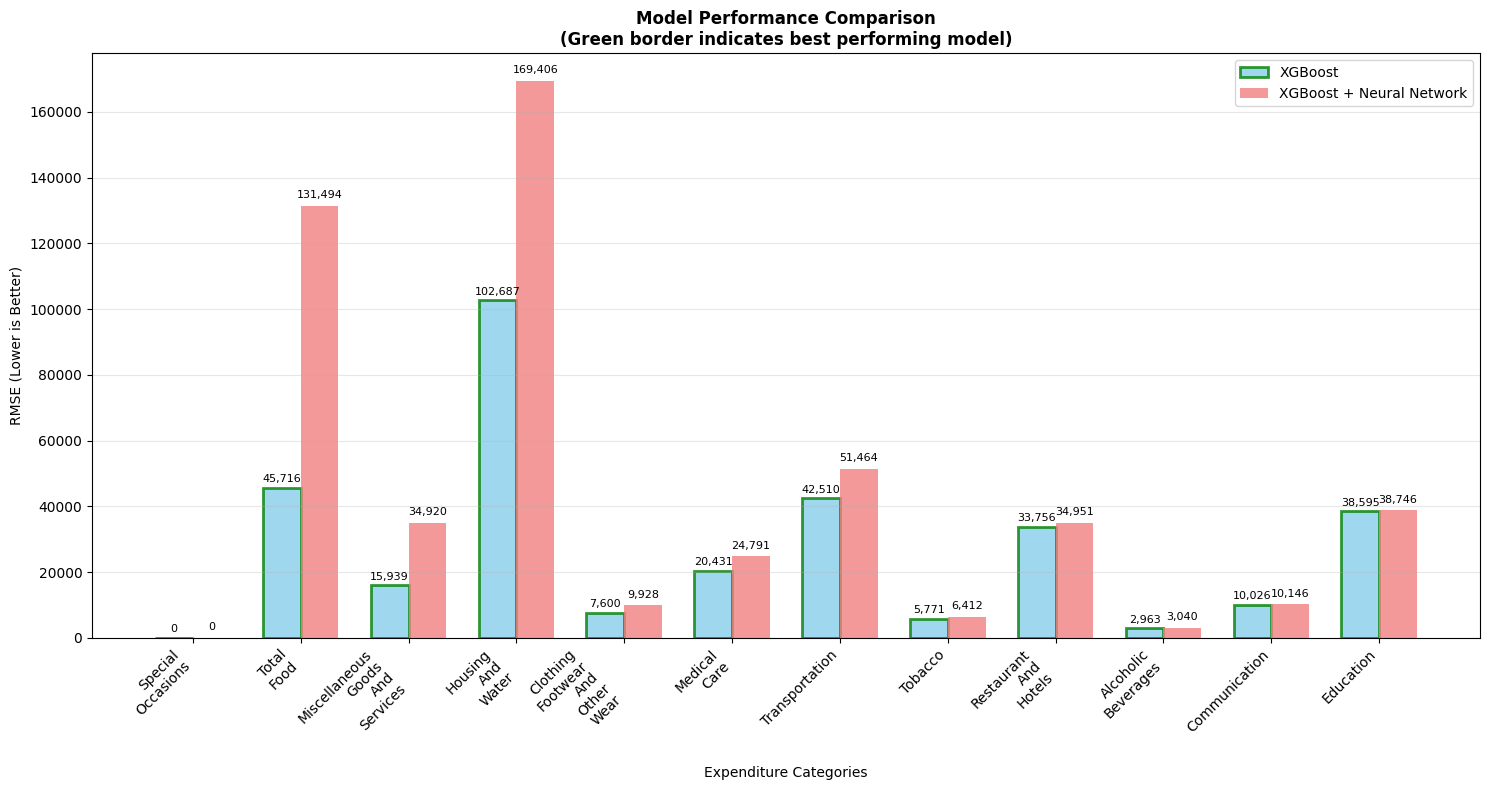


✓ Model comparison saved to 'models/model_comparison_results.csv'

=== Summary Statistics ===
           Improvement_%          
                    mean max count
Best_Model                        
XGBoost              inf inf    12


In [29]:
## 15) Model Selection dan Perbandingan

def train_and_compare_models(X_train, y_train, X_test, y_test):
    """Train dan compare XGBoost vs Ensemble models"""
    
    # XGBoost Models (sudah ada dari cell sebelumnya)
    print("Using existing XGBoost models...")
    
    # Ensemble Models (XGBoost + Neural Network)
    print("\nTraining Ensemble Models...")
    def create_ensemble_models(X_train, y_train, X_test, xgb_models):
        """Create ensemble combining XGBoost and Neural Networks"""
        
        # Get XGBoost predictions
        xgb_train_preds = pd.DataFrame(index=X_train.index if hasattr(X_train, 'index') else range(len(X_train)))
        xgb_test_preds = pd.DataFrame(index=X_test.index if hasattr(X_test, 'index') else range(len(X_test)))
        
        for category in primer + sekunder + tersier:
            xgb_train_preds[category] = xgb_models[category].predict(X_train)
            xgb_test_preds[category] = xgb_models[category].predict(X_test)
        
        # Train neural networks to combine predictions
        ensemble_models = {}
        ensemble_preds = {}
        
        for category in primer + sekunder + tersier:
            print(f"  Training ensemble for: {category}")
            
            # Neural network architecture
            model = models.Sequential([
                layers.Input(shape=(X_train.shape[1] + 1,)),  # Original + XGBoost prediction
                layers.Dense(128, activation='relu'),
                layers.BatchNormalization(),
                layers.Dropout(0.3),
                layers.Dense(64, activation='relu'),
                layers.BatchNormalization(),
                layers.Dropout(0.2),
                layers.Dense(32, activation='relu'),
                layers.Dense(1, activation='linear')
            ])
            
            model.compile(
                optimizer='adam',
                loss='mse',
                metrics=['mae']
            )
            
            # Prepare training data (original features + XGBoost predictions)
            xgb_train_array = xgb_train_preds[category].values.reshape(-1, 1)
            xgb_test_array = xgb_test_preds[category].values.reshape(-1, 1)
            
            X_train_ensemble = np.hstack([X_train, xgb_train_array])
            X_test_ensemble = np.hstack([X_test, xgb_test_array])
            
            # Callbacks
            callbacks_list = [
                callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7)
            ]
            
            # Train
            model.fit(
                X_train_ensemble, y_train[category],
                validation_split=0.2,
                epochs=100,
                batch_size=64,
                callbacks=callbacks_list,
                verbose=0
            )
            
            ensemble_models[category] = model
            ensemble_preds[category] = model.predict(X_test_ensemble).flatten()
        
        return ensemble_models, ensemble_preds
    
    # Train ensemble models
    ensemble_models, ensemble_predictions = create_ensemble_models(
        X_train_scaled, y_train_full, X_test_scaled, xgb_models
    )
    
    # Compare models
    print("\n=== Model Performance Comparison ===")
    
    comparison = pd.DataFrame()
    
    for category in primer + sekunder + tersier:
        # XGBoost metrics
        xgb_rmse = np.sqrt(mean_squared_error(y_test[category], xgb_predictions[category]))
        xgb_r2 = r2_score(y_test[category], xgb_predictions[category])
        
        # Ensemble metrics
        ens_rmse = np.sqrt(mean_squared_error(y_test[category], ensemble_predictions[category]))
        ens_r2 = r2_score(y_test[category], ensemble_predictions[category])
        
        # Determine which is better
        best_model = 'XGBoost' if xgb_rmse < ens_rmse else 'Ensemble'
        improvement = abs((xgb_rmse - ens_rmse) / xgb_rmse * 100)
        
        comparison = pd.concat([comparison, pd.DataFrame({
            'Category': [category.replace('_expenditure', '').replace('_', ' ').title()],
            'XGBoost_RMSE': [xgb_rmse],
            'XGBoost_R2': [xgb_r2],
            'Ensemble_RMSE': [ens_rmse],
            'Ensemble_R2': [ens_r2],
            'Best_Model': [best_model],
            'Improvement_%': [improvement]
        })], ignore_index=True)
    
    # Sort by improvement
    comparison = comparison.sort_values('Improvement_%', ascending=False)
    
    print(comparison.to_string(index=False))
    
    # Create final best models dictionary
    best_models = {}
    best_model_type = {}
    
    for _, row in comparison.iterrows():
        category_full = row['Category'].lower().replace(' ', '_') + '_expenditure'
        if row['Best_Model'] == 'XGBoost':
            best_models[category_full] = xgb_models[category_full]
            best_model_type[category_full] = 'xgboost'
        else:
            best_models[category_full] = ensemble_models[category_full]
            best_model_type[category_full] = 'ensemble'
    
    # Count which model type wins overall
    model_counts = pd.Series(best_model_type).value_counts()
    print(f"\n=== Overall Best Model ===")
    print(f"XGBoost wins for {model_counts.get('xgboost', 0)} categories")
    print(f"Ensemble wins for {model_counts.get('ensemble', 0)} categories")
    print(f"Overall winner: {model_counts.index[0]}")
    
    # Save best models to models folder
    os.makedirs('models', exist_ok=True)
    joblib.dump(best_models, 'models/best_models_final.pkl')
    joblib.dump(best_model_type, 'models/best_model_types.pkl')
    
    print("\n✓ Best models saved to 'models/best_models_final.pkl'")
    print("✓ Model types saved to 'models/best_model_types.pkl'")
    
    # Visualization
    plt.figure(figsize=(15, 8))
    categories = comparison['Category'].str.replace(' ', '\n')
    
    x_pos = np.arange(len(categories))
    width = 0.35
    
    bars1 = plt.bar(x_pos - width/2, comparison['XGBoost_RMSE'], width, 
                    label='XGBoost', alpha=0.8, color='skyblue')
    bars2 = plt.bar(x_pos + width/2, comparison['Ensemble_RMSE'], width, 
                    label='XGBoost + Neural Network', alpha=0.8, color='lightcoral')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(comparison['XGBoost_RMSE'])*0.01,
                 f'{height:,.0f}', ha='center', va='bottom', fontsize=8)
    
    for bar in bars2:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(comparison['Ensemble_RMSE'])*0.01,
                 f'{height:,.0f}', ha='center', va='bottom', fontsize=8)
    
    # Highlight best bars
    for i, row in comparison.iterrows():
        if row['Best_Model'] == 'XGBoost':
            bars1[i].set_edgecolor('green')
            bars1[i].set_linewidth(2)
        else:
            bars2[i].set_edgecolor('green')
            bars2[i].set_linewidth(2)
    
    plt.xlabel('Expenditure Categories')
    plt.ylabel('RMSE (Lower is Better)')
    plt.title('Model Performance Comparison\n(Green border indicates best performing model)', 
              fontweight='bold', fontsize=12)
    plt.xticks(x_pos, categories, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    return best_models, best_model_type, comparison

# Run model comparison
best_models, best_model_types, model_comparison = train_and_compare_models(
    X_train_scaled, y_train_full, X_test_scaled, y_test_full
)

# Save model comparison results
model_comparison.to_csv('models/model_comparison_results.csv', index=False)
print("\n✓ Model comparison saved to 'models/model_comparison_results.csv'")

# Summary statistics
summary_stats = model_comparison.groupby('Best_Model').agg({
    'Improvement_%': ['mean', 'max', 'count']
}).round(2)

print("\n=== Summary Statistics ===")
print(summary_stats)

=== Example: Budget Recommendation for Family ===
Monthly Income: 10,000,000 IDR | Family: 4 | Vehicles: 2
Generating budget for 3 month(s) ahead starting from 2025-10
Using default inflation: 0.210%

=== Budget Recommendation Summary ===
Average Monthly Expense: 2,018,545 IDR
Average Allocation - Primer: 88.3%, Sekunder: 11.0%, Tersier: 0.7%
Projected months: 2025-11, 2025-12, 2026-01

Recommendations DataFrame:
  month    month_name   income  total_expense  primer_total  sekunder_total  tersier_total
2025-11 November 2025 10000000   2,014,312.09  1,779,447.21      221,053.92      13,810.95
2025-12 December 2025 10000000   2,018,542.14  1,783,184.05      221,518.13      13,839.96
2026-01  January 2026 10000000   2,022,781.08  1,786,928.74      221,983.32      13,869.02


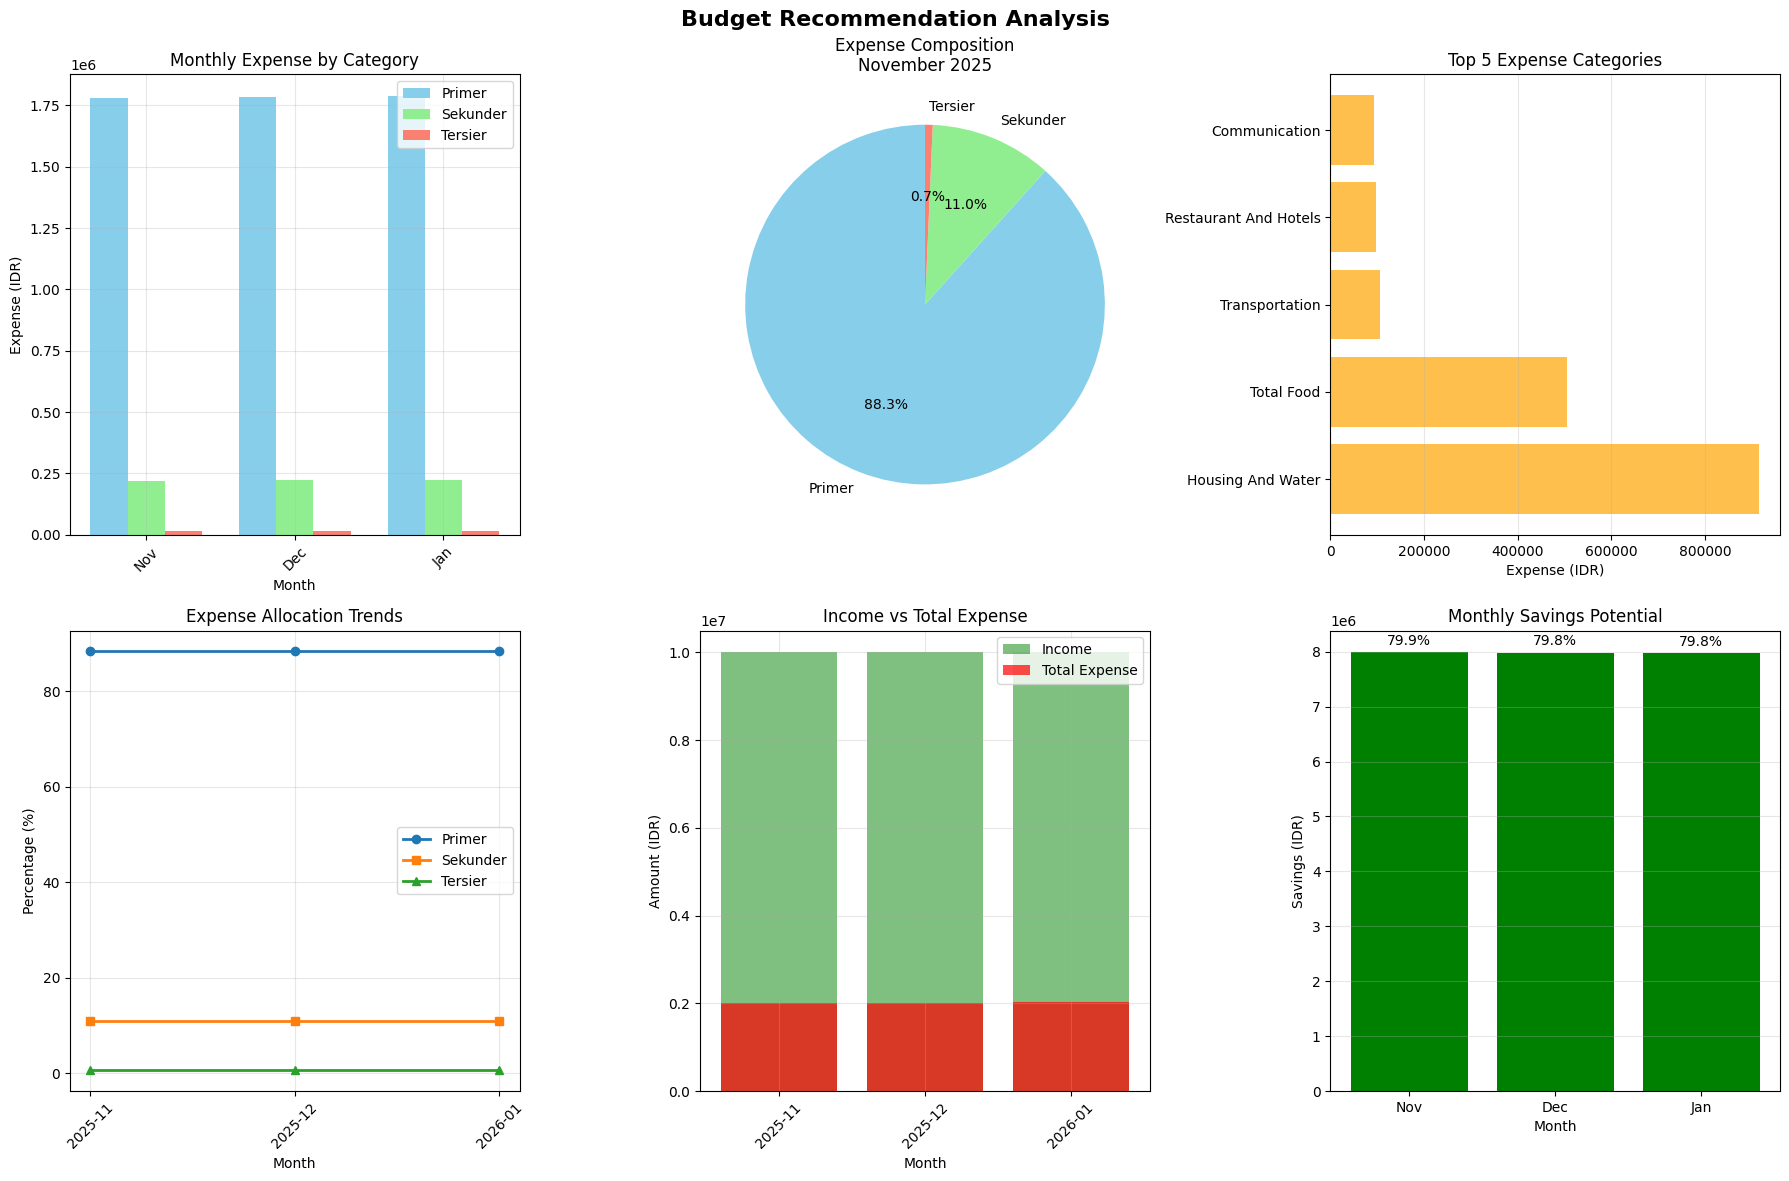

✓ Budget recommendations exported to family_budget_recommendation.csv
  Total months: 3
  Date range: 2025-11 to 2026-01


In [35]:
## 17) Budget Recommendation System dengan Multi-Month Projection

def predict_budget_optimized(income, family_size, vehicles=0, months_ahead=1, use_inflation=True):
    """
    Predict budget allocation for given household parameters
    
    Args:
        income: Monthly household income
        family_size: Number of family members
        vehicles: Number of vehicles owned
        months_ahead: Number of months to predict ahead
        use_inflation: Whether to apply inflation adjustment
    
    Returns:
        DataFrame with predicted expenditures for all categories
    """
    
    # Create input features
    import pandas as pd
    import numpy as np
    
    # Create feature DataFrame with proper structure
    features = pd.DataFrame({
        'total_income': [income],
        'family_size': [family_size],
        'total_vehicles': [vehicles]
    })
    
    # Calculate derived features
    features['income_per_capita'] = features['total_income'] / features['family_size']
    features['vehicles_per_capita'] = features['total_vehicles'] / features['family_size']
    features['region_encoded'] = [0]  # Default value
    
    # Define the feature order and keep it consistent
    feature_order = [
        'total_income',
        'family_size', 
        'total_vehicles',
        'income_per_capita',
        'vehicles_per_capita',
        'region_encoded'
    ]
    
    # Ensure all columns exist and reorder
    for col in feature_order:
        if col not in features.columns:
            features[col] = 0  # Default value if missing
    
    features = features[feature_order]
    
    # Create targets dictionary for all categories
    predictions = pd.DataFrame()
    
    # Get predictions for each category using best models
    for category in primer + sekunder + tersier:
        if category in best_models:
            model = best_models[category]
            
            # Make prediction based on model type
            if best_model_types.get(category) == 'xgboost':
                # XGBoost model prediction
                pred = model.predict(features)[0]
            else:
                # Ensemble model - needs XGBoost prediction as additional feature
                xgb_pred = xgb_models[category].predict(features)[0]
                # Combine original features with XGBoost prediction
                ensemble_features = np.column_stack([features.values, [xgb_pred]])
                pred = model.predict(ensemble_features)[0][0]
            
            predictions[category] = [pred]
        else:
            predictions[category] = [0]
    
    # Add derived columns (primer_total, sekunder_total, etc.)
    predictions['primer_total'] = predictions[primer].sum(axis=1)
    predictions['sekunder_total'] = predictions[sekunder].sum(axis=1)
    predictions['tersier_total'] = predictions[tersier].sum(axis=1)
    predictions['total_expense'] = predictions[primer + sekunder + tersier].sum(axis=1)
    
    # Apply inflation if requested
    if use_inflation and months_ahead > 1:
        inflation_rate = 0.21  # Default inflation rate
        inflation_factor = (1 + inflation_rate/100) ** (months_ahead - 1)
        
        for col in primer + sekunder + tersier:
            predictions[col] *= inflation_factor
        
        # Recalculate totals after inflation
        predictions['primer_total'] = predictions[primer].sum(axis=1)
        predictions['sekunder_total'] = predictions[sekunder].sum(axis=1)
        predictions['tersier_total'] = predictions[tersier].sum(axis=1)
        predictions['total_expense'] = predictions[primer + sekunder + tersier].sum(axis=1)
    
    # Calculate percentages
    total = predictions['total_expense'].iloc[0]
    if total > 0:
        for category in primer + sekunder + tersier:
            predictions[f'{category}_pct'] = predictions[category] / total * 100
        predictions['primer_pct'] = predictions['primer_total'] / total * 100
        predictions['sekunder_pct'] = predictions['sekunder_total'] / total * 100
        predictions['tersier_pct'] = predictions['tersier_total'] / total * 100
    
    return predictions

def generate_budget_recommendation(
    income, 
    family_size, 
    vehicles=0,
    start_month=None,
    months_ahead=3,
    use_inflation=True
):
    """
    Generate multi-month budget recommendations
    
    Args:
        income: Monthly household income
        family_size: Number of family members
        vehicles: Number of vehicles owned
        start_month: Start month in 'YYYY-MM' format (default: current month)
        months_ahead: Number of months to project AHEAD (1-3)
        use_inflation: Whether to apply inflation adjustment
    
    Returns:
        DataFrame with monthly budget recommendations for FUTURE months
    """
    
    # Validate months_ahead
    months_ahead = max(1, min(3, months_ahead))
    
    # Set start month (default to current)
    if start_month is None:
        start_month = datetime.now().strftime('%Y-%m')
    
    # Convert start_month to datetime (always use 1st day to avoid month-end issues)
    start_date = datetime.strptime(start_month + '-01', '%Y-%m-%d')
    
    print(f"Monthly Income: {income:,.0f} IDR | Family: {family_size} | Vehicles: {vehicles}")
    print(f"Generating budget for {months_ahead} month(s) ahead starting from {start_month}")
    
    # Load inflation data if available
    if use_inflation and os.path.exists('bps_inflation_data.csv'):
        inflation_data = pd.read_csv('bps_inflation_data.csv')
        if 'inflation_mom' in inflation_data.columns:
            # Get average inflation from data
            inflation_rate = inflation_data['inflation_mom'].mean()
            print(f"Using average inflation from BPS data: {inflation_rate:.3f}%")
        else:
            inflation_rate = 0.21
            print(f"Using default inflation: {inflation_rate:.3f}%")
    else:
        inflation_rate = 0.21
        print(f"Using default inflation: {inflation_rate:.3f}%")
    
    # Generate monthly projections for FUTURE months only
    recommendations = []
    
    # FIXED: Start from 1 to predict FUTURE months only
    # If months_ahead=2 and current month is October, it will predict November and December
    for month_offset in range(1, months_ahead + 1):
        # Calculate month date properly using pandas DateOffset
        # This ensures correct month progression without duplicates or skips
        current_date = pd.to_datetime(start_date) + pd.DateOffset(months=month_offset)
        month_label = current_date.strftime('%Y-%m')
        month_name = current_date.strftime('%B %Y')
        
        # Calculate cumulative inflation
        cumulative_inflation = ((1 + inflation_rate/100) ** month_offset - 1) * 100
        
        # Get base prediction
        base_pred = predict_budget_optimized(
            income=income,
            family_size=family_size,
            vehicles=vehicles,
            months_ahead=1,
            use_inflation=False  # We'll apply inflation manually
        )
        
        # Get first month data
        month_data = base_pred.iloc[0].copy()
        
        # Apply cumulative inflation
        inflation_factor = (1 + inflation_rate/100) ** month_offset
        for col in primer + sekunder + tersier:
            month_data[col] *= inflation_factor
        
        # Recalculate totals
        month_data['primer_total'] = month_data[primer].sum()
        month_data['sekunder_total'] = month_data[sekunder].sum()
        month_data['tersier_total'] = month_data[tersier].sum()
        month_data['total_expense'] = month_data[primer + sekunder + tersier].sum()
        
        # Create recommendation record
        rec = {
            'month': month_label,
            'month_name': month_name,
            'income': income,
            'family_size': family_size,
            'vehicles': vehicles,
            'cumulative_inflation_pct': cumulative_inflation,
            'inflation_adjusted': True,  # Always True for future months
            'month_offset': month_offset  # Track how many months ahead
        }
        
        # Add all predictions
        for col in base_pred.columns:
            rec[col] = month_data[col]
        
        recommendations.append(rec)
    
    # Convert to DataFrame
    rec_df = pd.DataFrame(recommendations)
    
    # Summary statistics
    avg_total_expense = rec_df['total_expense'].mean()
    avg_primer_pct = rec_df['primer_pct'].mean()
    avg_sekunder_pct = rec_df['sekunder_pct'].mean()
    avg_tersier_pct = rec_df['tersier_pct'].mean()
    
    print(f"\n=== Budget Recommendation Summary ===")
    print(f"Average Monthly Expense: {avg_total_expense:,.0f} IDR")
    print(f"Average Allocation - Primer: {avg_primer_pct:.1f}%, Sekunder: {avg_sekunder_pct:.1f}%, Tersier: {avg_tersier_pct:.1f}%")
    print(f"Projected months: {', '.join(rec_df['month'].tolist())}")
    
    return rec_df

def visualize_budget_recommendations(rec_df):
    """
    Visualize budget recommendations with multiple charts
    
    Args:
        rec_df: DataFrame from generate_budget_recommendation
    """
    
    # Set up the figure
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Budget Recommendation Analysis', fontsize=16, fontweight='bold')
    
    # 1. Monthly Expense Trend
    ax1 = axes[0, 0]
    x_pos = np.arange(len(rec_df))
    width = 0.25
    
    ax1.bar(x_pos - width, rec_df['primer_total'], width, label='Primer', color='skyblue')
    ax1.bar(x_pos, rec_df['sekunder_total'], width, label='Sekunder', color='lightgreen')
    ax1.bar(x_pos + width, rec_df['tersier_total'], width, label='Tersier', color='salmon')
    
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Expense (IDR)')
    ax1.set_title('Monthly Expense by Category')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(rec_df['month_name'].str[:3], rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Expense Composition (Pie Chart for First Month)
    ax2 = axes[0, 1]
    first_month = rec_df.iloc[0]
    sizes = [first_month['primer_total'], first_month['sekunder_total'], first_month['tersier_total']]
    labels = ['Primer', 'Sekunder', 'Tersier']
    colors = ['skyblue', 'lightgreen', 'salmon']
    
    ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax2.set_title(f'Expense Composition\n{first_month["month_name"]}')
    
    # 3. Detailed Category Breakdown
    ax3 = axes[0, 2]
    detailed_expenses = []
    for cat in primer + sekunder + tersier:
        detailed_expenses.append((cat.replace('_expenditure', '').replace('_', ' ').title(), 
                               first_month[cat]))
    
    detailed_expenses.sort(key=lambda x: x[1], reverse=True)
    categories, amounts = zip(*detailed_expenses[:5])  # Top 5
    
    ax3.barh(categories, amounts, color='orange', alpha=0.7)
    ax3.set_xlabel('Expense (IDR)')
    ax3.set_title('Top 5 Expense Categories')
    ax3.grid(True, alpha=0.3, axis='x')
    
    # 4. Percentage Allocation Over Time
    ax4 = axes[1, 0]
    ax4.plot(rec_df['month'], rec_df['primer_pct'], marker='o', label='Primer', linewidth=2)
    ax4.plot(rec_df['month'], rec_df['sekunder_pct'], marker='s', label='Sekunder', linewidth=2)
    ax4.plot(rec_df['month'], rec_df['tersier_pct'], marker='^', label='Tersier', linewidth=2)
    
    ax4.set_xlabel('Month')
    ax4.set_ylabel('Percentage (%)')
    ax4.set_title('Expense Allocation Trends')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_xticklabels(rec_df['month'], rotation=45)
    
    # 5. Income vs Expense
    ax5 = axes[1, 1]
    ax5.bar(rec_df['month'], rec_df['income'], alpha=0.5, label='Income', color='green')
    ax5.bar(rec_df['month'], rec_df['total_expense'], alpha=0.7, label='Total Expense', color='red')
    
    ax5.set_xlabel('Month')
    ax5.set_ylabel('Amount (IDR)')
    ax5.set_title('Income vs Total Expense')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    ax5.set_xticklabels(rec_df['month'], rotation=45)
    
    # 6. Savings Potential
    ax6 = axes[1, 2]
    savings = rec_df['income'] - rec_df['total_expense']
    savings_pct = (savings / rec_df['income']) * 100
    
    bars = ax6.bar(rec_df['month_name'].str[:3], savings, 
                   color=['green' if s > 0 else 'red' for s in savings])
    
    ax6.set_xlabel('Month')
    ax6.set_ylabel('Savings (IDR)')
    ax6.set_title('Monthly Savings Potential')
    ax6.grid(True, alpha=0.3, axis='y')
    
    # Add percentage labels on bars
    for i, (bar, pct) in enumerate(zip(bars, savings_pct)):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., 
                 height + (max(savings) * 0.01 if max(savings) > 0 else min(savings) * 0.01),
                 f'{pct:.1f}%', ha='center', 
                 va='bottom' if height >= 0 else 'top')
    
    plt.tight_layout()
    plt.show()

def export_recommendations_to_csv(recommendations, filename="budget_recommendations.csv"):
    """
    Export budget recommendations to CSV file
    
    Args:
        recommendations: DataFrame from generate_budget_recommendation
        filename: Output CSV filename
    """
    # Create a copy for export
    export_df = recommendations.copy()
    
    # Reorder columns for better readability
    main_cols = ['month', 'month_name', 'income', 'total_expense', 'primer_total', 
                 'sekunder_total', 'tersier_total', 'cumulative_inflation_pct']
    
    # Find all expense category columns
    expense_cols = [col for col in export_df.columns if col.endswith('_expenditure')]
    
    # Find all percentage columns
    pct_cols = [col for col in export_df.columns if col.endswith('_pct')]
    
    # Combine all columns in desired order
    all_cols = main_cols + expense_cols + pct_cols
    all_cols = [col for col in all_cols if col in export_df.columns]
    
    export_df = export_df[all_cols]
    
    # Format numeric columns for better readability
    for col in ['income', 'total_expense', 'primer_total', 'sekunder_total', 'tersier_total']:
        if col in export_df.columns:
            export_df[col] = export_df[col].round(0).astype(int)
    
    export_df.to_csv(filename, index=False)
    print(f"✓ Budget recommendations exported to {filename}")
    print(f"  Total months: {len(export_df)}")
    print(f"  Date range: {export_df['month'].min()} to {export_df['month'].max()}")

# Example usage
print("=== Example: Budget Recommendation for Family ===")
recommendations = generate_budget_recommendation(
    income=10000000,  # 10 juta IDR
    family_size=4,
    vehicles=2,
    start_month="2025-10",  # October 2025
    months_ahead=3,  # Predict for next 2 months (November & December)
    use_inflation=True
)

print("\nRecommendations DataFrame:")
print(recommendations[['month', 'month_name', 'income', 'total_expense', 'primer_total', 
                      'sekunder_total', 'tersier_total']].to_string(index=False))

# Visualize recommendations
visualize_budget_recommendations(recommendations)

# Export to CSV
export_recommendations_to_csv(recommendations, "family_budget_recommendation.csv")